In [4]:
from copy import deepcopy
import numpy as np
import plotly.graph_objects as go

class DisplayFigs:
    def _rgb_to_hex(rgb):
        '''Convert colors to Plotly hex color strings'''
        rgb255 = (rgb * 255).astype(int)
        return ['rgb({},{},{})'.format(r, g, b) for r, g, b in rgb255]


    def display_plotly_orig_and_clouds(orig_fig, cloud_figs: set):
        # Extract metadata for origin figure
        verts_fig = np.asarray(orig_fig.vertices)
        tris_fig = np.asarray(orig_fig.triangles)
        orig_colors = np.asarray(orig_fig.vertex_colors) if orig_fig.has_vertex_colors() else np.full(verts_fig.shape, [128/255, 26/255, 107/255])

        # Exrtact metadata for cloud figures
        cloud_figs_points = []
        cloud_figs_colors_hex = []
        for cloud_fig in cloud_figs:
            cloud_figs_points.append(np.asarray(cloud_fig.points))

            fig_colors = np.asarray(cloud_fig.colors) if cloud_fig.has_colors() else np.tile([0, 0, 1], (len(cloud_fig.points), 1))
        
            cloud_figs_colors_hex.append(DisplayFigs._rgb_to_hex(fig_colors))

        orig_trace = go.Mesh3d(
            x=verts_fig[:, 0], y=verts_fig[:, 1], z=verts_fig[:, 2],
            i=tris_fig[:, 0], j=tris_fig[:, 1], k=tris_fig[:, 2],
            vertexcolor=orig_colors,
            opacity=0.8,
            showlegend=False,
            name=''
        )

        cloud_figs_trace = []
        for points, colors in zip(cloud_figs_points, cloud_figs_colors_hex):
            cloud_figs_trace.append(go.Scatter3d(
                x=points[:, 0], y=points[:, 1], z=points[:, 2],
                mode='markers',
                marker=dict(size=2, color=colors),
                showlegend=False,
                name=''
            ))

        merged_trace = [orig_trace,] + cloud_figs_trace

        fig = go.Figure(data=merged_trace)

        fig.update_layout(
            showlegend=False,
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False),
                aspectmode='data'
            ),
            margin=dict(t=0, l=0, r=0, b=0)
        )

        fig.show(config={'displayModeBar': False})


    def display_plotly_origs(orig_figs: set, offset_step=1.0):
        traces = []
        for idx, orig_fig in enumerate(orig_figs):
            vertices = np.asarray(orig_fig.vertices)
            triangles = np.asarray(orig_fig.triangles)
            color = np.asarray(orig_fig.vertex_colors) if orig_fig.has_vertex_colors() else np.full(vertices.shape, [128/255, 26/255, 107/255])

            # Apply offset to vertices along x-axis:
            offset = np.array([offset_step * idx, 0, 0])
            vertices_offset = vertices + offset

            traces.append(
                go.Mesh3d(
                    x=vertices_offset[:, 0], y=vertices_offset[:, 1], z=vertices_offset[:, 2],
                    i=triangles[:, 0], j=triangles[:, 1], k=triangles[:, 2],
                    vertexcolor=color,
                    opacity=0.8,
                    showlegend=False,
                    name=''
                )
            )

        fig = go.Figure(data=traces)

        fig.update_layout(
            showlegend=False,
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False),
                aspectmode='data'
            ),
            margin=dict(t=0, l=0, r=0, b=0)
        )

        fig.show(config={'displayModeBar': False})


    def display_plotly_clouds(cloud_figs: set, non_in_line=False, offset_step=3.0):
        cloud_figs_trace = []
        for i, cloud_fig in enumerate(cloud_figs):
            points = np.asarray(cloud_fig.points)
            color = DisplayFigs._rgb_to_hex(
                np.asarray(cloud_fig.colors) if cloud_fig.has_colors() else np.tile([1.0, 0.75, 0.0], (len(cloud_fig.points), 1))
            )

            offset_points = deepcopy(points)
            if non_in_line:
                offset_points[:, 0] += i * offset_step

            cloud_figs_trace.append(go.Scatter3d(
                x=offset_points[:, 0], y=offset_points[:, 1], z=offset_points[:, 2],
                mode='markers',
                marker=dict(size=2, color=color),
                showlegend=False,
                name=''
            ))

        fig = go.Figure(data=cloud_figs_trace)

        fig.update_layout(
            showlegend=False,
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False),
                aspectmode='data'
            ),
            margin=dict(t=0, l=0, r=0, b=0)
        )

        fig.show(config={'displayModeBar': False})

In [1]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

### Сегментация трёхмерных облаков точек методом DBSCAN

При работе с облаками точек, полученными, с сенсоров одной из ключевых задач является **кластеризация** — объединение точек, принадлежащих к одному объекту или локальной группе, в отдельные сегменты.

Для этой цели широко применяется алгоритм **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**, предложенный М. Эстером и соавторами в 1996 году. Он основан на анализе **плотности распределения точек** в пространстве и позволяет выделять области с высокой плотностью, отделяя их от разреженного «шума».

В библиотеке **Open3D** алгоритм реализован в виде функции
`open3d.geometry.PointCloud.cluster_dbscan()`,
которая принимает два основных параметра:

* **eps** — радиус окрестности (в метрах), определяющий максимально допустимое расстояние между соседними точками, которые могут принадлежать одному кластеру;
* **min_points** — минимальное количество точек, необходимое для образования кластера. Если точка имеет меньше соседей, чем `min_points`, она считается шумовой (outlier) и получает метку `-1`.

Результатом выполнения функции является массив меток для каждой точки облака, где одинаковые значения соответствуют одной группе (кластеру).
Метки `-1` указывают на **точки-шум**, не принадлежащие ни к одному из кластеров.

Достоинство DBSCAN заключается в том, что:

* он **не требует заранее задавать число кластеров**;
* **устойчив к выбросам и шуму**;

In [ ]:
ply_point_cloud = o3d.data.PLYPointCloud()
pcd = o3d.io.read_point_cloud(ply_point_cloud.path)

labels = np.array(pcd.cluster_dbscan(eps=0.02, min_points=10, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd],
                                  zoom=0.455,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])

point cloud has 60 clusters


In [26]:
ply_point_cloud = o3d.data.PLYPointCloud()
pcd = o3d.io.read_point_cloud(ply_point_cloud.path)
points = np.asarray(pcd.points)

db = DBSCAN(eps=0.02, min_samples=10, metric='euclidean', n_jobs=-1)
labels = db.fit_predict(points)

max_label = labels.max()

print(f"point cloud has {max_label + 1} clusters")

denominator = max_label if max_label > 0 else 1
normalized = np.clip(labels.astype(float) / denominator, 0, 1)
colors = plt.get_cmap("tab20")(normalized)
colors[labels < 0] = 0.0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

o3d.visualization.draw_geometries(
    [pcd],
    zoom=0.455,
    front=[-0.4999, -0.1659, -0.8499],
    lookat=[2.1813, 2.0619, 2.0999],
    up=[0.1204, -0.9852, 0.1215],
)

point cloud has 10 clusters


### Сравнение реализаций DBSCAN в Open3D и scikit-learn

Алгоритм DBSCAN (Density-Based Spatial Clustering of Applications with Noise) в обеих библиотеках основан на одном и том же принципе плотностной кластеризации, однако отличается реализацией, интерфейсом и областью применения. Реализация в Open3D ориентирована на трёхмерные облака точек, тогда как scikit-learn предоставляет универсальный инструмент для многомерных признаковых пространств и различных метрик расстояния.

**Тип данных и используемая метрика.**
В Open3D алгоритм работает непосредственно с объектами типа `PointCloud` и всегда использует евклидову метрику в трёхмерном пространстве координат (X, Y, Z). Пользователь задаёт параметры в тех же единицах, в которых измеряются координаты точек, поэтому выбор значения радиуса `eps` напрямую зависит от масштаба сцены.
В scikit-learn кластеризация проводится над произвольной матрицей признаков или заранее вычисленных расстояний. Библиотека поддерживает широкий набор метрик: евклидову, манхэттенскую, косинусную, хемингову, Минковского и другие. Это делает её более гибкой в применении к задачам, выходящим за рамки трёхмерной геометрии.

**Интерфейс и возвращаемые данные.**
Функция `cluster_dbscan` в Open3D возвращает только массив меток кластеров, где значение –1 соответствует шумовым точкам. Объектной модели алгоритма не создаётся, и дополнительных сведений, таких как индексы ядерных (core) или пограничных (border) точек, не предоставляется.
В scikit-learn DBSCAN реализован в виде класса `DBSCAN` с методами `fit` и `fit_predict`. После обучения доступны атрибуты `labels_`, `core_sample_indices_` и `components_`, что позволяет анализировать структуру кластеров и интегрировать алгоритм в сложные машинно-обучающие конвейеры (Pipeline, GridSearchCV и др.).

**Поиск соседей и вычислительная эффективность.**
Open3D оптимизирован для работы с трёхмерными облаками точек и использует внутренние структуры пространственного индексирования (например, k-d дерево) и параллелизм на уровне ядра процессора. Это обеспечивает высокую производительность и умеренное потребление памяти при обработке больших облаков.
В scikit-learn поиск ближайших соседей осуществляется с помощью объекта `NearestNeighbors`, который может использовать k-d дерево, ball-tree или полный перебор в зависимости от размерности данных и выбранной метрики. Параллелизация контролируется параметром `n_jobs`. Производительность в этом случае зависит от структуры данных и выбранного метода поиска соседей.

**Гибкость и интеграция в экосистему.**
Open3D предлагает минималистичную, но глубоко интегрированную реализацию, ориентированную на задачи геометрической обработки трёхмерных сцен: фильтрацию, вычисление нормалей, дескрипторов FPFH, сегментацию плоскостей и визуализацию.
Реализация в scikit-learn обладает значительно большей гибкостью за счёт дополнительных параметров, таких как `sample_weight` для взвешивания образцов, и тесной интеграции с другими алгоритмами машинного обучения. Это делает её предпочтительной в случаях, когда требуется кросс-валидация, построение сложных конвейеров или исследование гиперпараметров.

**Интерпретация результатов и возможность повторного применения.**
DBSCAN не формирует модель, пригодную для прогнозирования кластеров новых точек. Оба варианта реализуют одноразовую кластеризацию текущего набора данных. Однако в scikit-learn структура объекта позволяет повторно использовать параметры модели или применять её в рамках обучающего конвейера, тогда как в Open3D функция вызывается непосредственно над конкретным облаком точек и не сохраняет внутреннее состояние.

Таким образом, реализация DBSCAN в Open3D ориентирована на высокопроизводительную обработку геометрических данных в трёхмерном пространстве и тесно интегрирована с другими средствами анализа и визуализации облаков точек. Реализация в scikit-learn, напротив, универсальна, гибка в выборе метрик и конфигураций, но менее специализирована для трёхмерных сцен. Выбор конкретного инструмента определяется задачей: Open3D предпочтителен для пространственных данных, scikit-learn — для анализа многомерных признаков в рамках более широких машинно-обучающих процессов.


### Выпуклая оболочка трёхмерного облака точек

**Определение.** Выпуклая оболочка множества точек $X={\mathbf{x}*i}*{i=1}^N \subset \mathbb{R}^3$ — наименьшее выпуклое множество $\mathrm{conv}(X)$, содержащее все точки $X$. Эквивалентно,

$$
\mathrm{conv}(X) =
\left\{
\sum_{i=1}^{N} \lambda_i \mathbf{x}_i
\;\middle|\;
\lambda_i \ge 0,\;
\sum_{i=1}^{N} \lambda_i = 1
\right\}.
$$

В Open3D выпуклая оболочка вычисляется методом `compute_convex_hull`. Реализация опирается на библиотеку Qhull и возвращает треугольную сетку, аппроксимирующую границу $\partial,\mathrm{conv}(X)$.

**Свойства и вычислительная сложность.** Граница выпуклой оболочки представляет собой замкнутую полиэдральную поверхность, полностью охватывающую исходное облако точек. Типичная асимптотика алгоритмов построения в (\mathbb{R}^3) — (O(N \log N)) по числу точек, при зависимости от числа граней выходной оболочки.

### Почему это может использоваться в сегментации

1. **Оболочка описывает форму выделенного объекта.**

   После кластеризации (например, методом DBSCAN) мы можем построить выпуклую оболочку для каждой группы точек.
   Это даёт нам простую поверхность, которая описывает общий контур объекта, даже если точки распределены неравномерно.

2. **Это способ построить границы сегмента.**

   Сегментация — это разделение сцены на отдельные объекты.
   Выпуклая оболочка каждой группы точек фактически задаёт *границы* этих объектов.
   По сути, она выполняет роль «маски» в 3D: всё, что внутри оболочки, считается принадлежащим объекту.

3. **Оболочка помогает убрать выбросы.**

   Если в облаке есть редкие точки, «оторванные» от основной массы, они будут лежать за пределами оболочки.
   Это позволяет автоматически исключить такие точки как шум.

4. **Можно оценить геометрию сегмента.**

   У выпуклой оболочки легко вычислить площадь и объём. Эти характеристики полезны для анализа — например, чтобы сравнивать размеры сегментов или находить дефекты.

In [ ]:
bunny = o3d.data.BunnyMesh()
mesh = o3d.io.read_triangle_mesh(bunny.path)

# DisplayFigs.display_plotly_origs((mesh, ))

mesh.compute_vertex_normals()

pcl = mesh.sample_points_poisson_disk(number_of_points=2000)
hull, _ = pcl.compute_convex_hull()
hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
hull_ls.paint_uniform_color((1, 0, 0))
o3d.visualization.draw_geometries([pcl, hull_ls])

### Сегментация плоскости

В библиотеке **Open3D** реализована поддержка выделения простых геометрических примитивов из облаков точек с использованием метода **RANSAC** (Random Sample Consensus).
Для нахождения плоскости, наилучшим образом описывающей максимальное число точек облака, используется функция `segment_plane`.

Метод принимает три основных аргумента:

* **distance_threshold** — максимальное расстояние, на котором точка может находиться от предполагаемой плоскости, чтобы считаться принадлежащей ей (включаться в набор *inlier*-ов);
* **ransac_n** — количество точек, случайно выбираемых на каждой итерации для оценки параметров плоскости;
* **num_iterations** — число итераций, то есть сколько раз алгоритм будет случайным образом выбирать подмножества точек и проверять качество найденных моделей.

Функция возвращает параметры плоскости в виде коэффициентов $a, b, c, d$ уравнения

$$
a x + b y + c z + d = 0,
$$

таких, что для каждой точки ((x_i, y_i, z_i)), лежащей на плоскости, выполняется указанное соотношение.
Также метод возвращает список индексов точек, которые считаются принадлежащими найденной плоскости (внутренние точки, *inliers*).

---

**Пример использования:**

```python
import open3d as o3d

pcd = o3d.io.read_point_cloud("pointcloud.pcd")

plane_model, inliers = pcd.segment_plane(
    distance_threshold=0.01,
    ransac_n=3,
    num_iterations=1000
)

[a, b, c, d] = plane_model
print(f"Уравнение плоскости: {a:.3f}x + {b:.3f}y + {c:.3f}z + {d:.3f} = 0")

plane_cloud = pcd.select_by_index(inliers)
plane_cloud.paint_uniform_color([1.0, 0, 0])
non_plane_cloud = pcd.select_by_index(inliers, invert=True)

o3d.visualization.draw_geometries([plane_cloud, non_plane_cloud])
```

---

Таким образом, функция `segment_plane` позволяет выделить основную плоскость в облаке точек (например, пол, стену или столешницу), что часто используется как первый этап в задачах **геометрической сегментации** сцены и выделения объектов, расположенных на определённой поверхности.


In [229]:
pcd_point_cloud = o3d.data.PLYPointCloud()
pcd = o3d.io.read_point_cloud(pcd_point_cloud.path)

o3d.visualization.draw_geometries([pcd],
                                  zoom=0.8,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])

plane_model, inliers = pcd.segment_plane(distance_threshold=0.05,
                                         ransac_n=3,
                                         num_iterations=1000)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)



o3d.visualization.draw_geometries([inlier_cloud],
                                  zoom=0.8,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])

o3d.visualization.draw_geometries([outlier_cloud],
                                  zoom=0.8,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])

Plane equation: 0.33x + 0.00y + 0.95z + -2.49 = 0


In [29]:
pcd = outlier_cloud

o3d.visualization.draw_geometries([pcd],
                                  zoom=0.8,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])

plane_model, inliers = pcd.segment_plane(distance_threshold=0.05,
                                         ransac_n=3,
                                         num_iterations=1000)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)



o3d.visualization.draw_geometries([inlier_cloud],
                                  zoom=0.8,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])

o3d.visualization.draw_geometries([outlier_cloud],
                                  zoom=0.8,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])

Plane equation: -0.00x + 1.00y + 0.03z + -2.42 = 0


In [30]:
mesh = o3d.geometry.TriangleMesh.create_box(width=1.0, height=1.0, depth=1.0)
mesh.translate([-0.5, -0.5, -0.5])
mesh.compute_vertex_normals()

pcd = mesh.sample_points_poisson_disk(number_of_points=2000)

planes = []
rest = pcd
max_planes = 6

for i in range(max_planes):
    plane_model, inliers = rest.segment_plane(
        distance_threshold=0.01,
        ransac_n=3,
        num_iterations=500
    )

    if len(inliers) < 50:
        break

    [a, b, c, d] = plane_model
    print(f"Плоскость {i + 1}: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0, точек: {len(inliers)}")

    plane_cloud = rest.select_by_index(inliers)
    plane_cloud.paint_uniform_color(np.random.rand(3))
    planes.append(plane_cloud)
    o3d.visualization.draw_geometries([plane_cloud])

    rest = rest.select_by_index(inliers, invert=True)

o3d.visualization.draw_geometries(planes + [rest])


Плоскость 1: -0.00x + 0.00y + 1.00z + 0.50 = 0, точек: 363
Плоскость 2: -0.00x + 0.00y + 1.00z + -0.50 = 0, точек: 355
Плоскость 3: 0.00x + 1.00y + 0.00z + 0.50 = 0, точек: 329
Плоскость 4: -0.00x + 1.00y + -0.00z + -0.50 = 0, точек: 327
Плоскость 5: 1.00x + 0.00y + 0.00z + -0.50 = 0, точек: 315
Плоскость 6: 1.00x + 0.00y + -0.00z + 0.50 = 0, точек: 311
[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.


## Детектирование плоских фрагментов (Planar Patch Detection)

Помимо нахождения одной доминирующей плоскости методом RANSAC, библиотека **Open3D** реализует более продвинутый алгоритм **детектирования плоских фрагментов** (planar patches), основанный на устойчивых статистических методах [Arujo and Oliveira, 2020].
В отличие от RANSAC, который ищет одну «глобальную» плоскость, данный подход выявляет **множество локальных плоских участков** — то есть группы точек, лежащие на различных небольших плоскостях сцены.

### 1. Основная идея алгоритма

Алгоритм выполняется в несколько этапов:

1. **Декомпозиция сцены.**

   Исходное облако точек делится на мелкие области при помощи **октодерева (octree)**.
   Каждая ячейка содержит локально близкие точки.

2. **Подгонка плоскости к каждой ячейке.**

   Для каждой локальной группы точек пытаются аппроксимировать плоскость.
   Плоскость определяется через **медианное положение точки** и **медианную нормаль** среди нормалей точек ячейки.
   Если параметры нормали и положения удовлетворяют критерию устойчивости, плоскость принимается как валидная.

3. **Проверка устойчивости (robust planarity test).**

   Используется два критерия:

   * **Оценка разброса нормалей.**
     Для всех точек ячейки вычисляются углы между их нормалями и нормалью найденной плоскости.
     Если разброс углов слишком велик, участок отклоняется.
   * **Оценка копланарности.**
     Для всех точек измеряется расстояние до плоскости.
     Если распределение этих расстояний имеет слишком большую дисперсию, участок также отклоняется.

4. **Рост и слияние плоскостей.**

   После начальной оценки плоскостей алгоритм итеративно расширяет и объединяет соседние фрагменты, принадлежащие одной и той же плоскости.
   В результате формируется компактное и стабильное множество плоских областей.

   Для каждой пары фрагментов патчей $P_i$ и $P_j$:

    1. **Угол между нормалями**

        $
        \theta = \arccos(\mathbf{n}_i \cdot \mathbf{n}_j)
        $


        Если угол меньше заданного порога (например, 5–10°), патчи считаются ориентированными примерно одинаково.
        Это — **основной критерий**.

    2. **Разность расстояний до начала координат**

        Каждая плоскость задаётся уравнением:
        $
        \mathbf{n} \cdot \mathbf{x} + d = 0
        $
        Проверяется, насколько близки константы $d_i$ и $d_j$.

        Если разность |dᵢ − dⱼ| меньше некоторого порога (например, нескольких сантиметров относительно масштаба облака), значит, плоскости не только параллельны, но и **почти копланарны**.

    3. **Перекрытие в пространстве (опционально)**

        Если ограничивающие коробки (OBB) патчей пересекаются или близко расположены — это усиливает аргумент в пользу слияния.
        (В исходной реализации Open3D это используется неявно через близость точек.)


    4. Что происходит после слияния

        * Точки двух фрагментов объединяются.
        * Плоскость пересчитывается заново по объединённым точкам.
        * Новая нормаль переоценивается по точкам.
        * Алгоритм рекурсивно проверяет, можно ли объединить новообразованный патч с другими соседними.

5. **Выделение патчей.**

   Для каждой найденной плоскости вычисляется **2D-выпуклая оболочка** соответствующих точек, которая ограничивает плоский фрагмент в пределах его геометрических границ.

### 2. Использование в Open3D

Для запуска алгоритма используется метод

```python
detect_planar_patches()
```

Функция возвращает **список обнаруженных плоских фрагментов**, каждый из которых представлен объектом
`geometry.OrientedBoundingBox`.

Третий столбец матрицы вращения `R` в объекте OBB соответствует нормали к найденной плоскости.
Толщина (extent) вдоль нормали остаётся ненулевой, чтобы прямоугольная область включала все точки, участвовавшие в аппроксимации.

### 4. Применение в задачах сегментации

Детекция плоских патчей является важным инструментом в **геометрической сегментации 3D-сцен**, особенно для инженерных, архитектурных и робототехнических приложений.
Она используется для:

* выделения **структурных элементов** (стены, пол, потолок, столешницы);
* **аппроксимации поверхности объектов**, имеющих плоские части;
* построения **упрощённой модели сцены** (например, при реконструкции помещений);
* **предварительного разделения** сцены перед применением нейросетевых методов сегментации;
* ускорения поиска объектов, опирающихся на плоские основания (например, коробки, панели, детали).

Таким образом, алгоритм детектирования плоских фрагментов — это более общий и устойчивый аналог поиска одной плоскости по RANSAC, способный находить **множество локальных плоских областей** с автоматической фильтрацией шумов и ложных срабатываний.

```python
def detect_planar_patches(
    self,
    normal_variance_threshold_deg: float = 60.0,
    coplanarity_deg: float = 75.0,
    outlier_ratio: float = 0.75,
    min_plane_edge_length: float = 0.01,  # 1% от размера сцены
    min_num_points: int = 0,  # 0.1% от общего числа точек
    search_param: KDTreeSearchParam = KDTreeSearchParamKNN()
) -> List[OrientedBoundingBox]:
    """
    Параметры:
    -----------
    normal_variance_threshold_deg : float
        Максимально допустимое отклонение нормалей точек от нормали плоскости (в градусах).
        Меньшие значения дают более строгий отбор.
        Значение по умолчанию: 60°

    coplanarity_deg : float
        Допустимая дисперсия расстояний от точек до плоскости (в градусах).
        Меньшие значения обеспечивают более плотные и точные патчи.
        Значение по умолчанию: 75°

    outlier_ratio : float
        Максимальная доля выбросов в пределах плоскости.
        При превышении этого значения плоскость отбрасывается.
        Значение по умолчанию: 0.75

    min_plane_edge_length : float
        Минимальная длина ребра патча для отсечения ложных срабатываний.
        Рассчитывается как процент от размера сцены.
        Значение по умолчанию: 1% от размера сцены

    min_num_points : int
        Минимальное число точек в ячейке для попытки подгонки плоскости.
        Определяет глубину октодерева.
        Значение по умолчанию: 0.1% от общего числа точек

    search_param : KDTreeSearchParam
        Параметр поиска соседей при росте/слиянии патчей.
        Значение по умолчанию: KDTreeSearchParamKNN

    Возвращаемое значение:
    ---------------------
    List[OrientedBoundingBox]
        Список ориентированных ограничивающих рамок, описывающих обнаруженные плоские патчи
    """
```

In [ ]:
dataset = o3d.data.PCDPointCloud()
pcd = o3d.io.read_point_cloud(dataset.path)

# pcd_point_cloud = o3d.data.PLYPointCloud()
# pcd = o3d.io.read_point_cloud(pcd_point_cloud.path)

assert (pcd.has_normals())

# using all defaults
oboxes = pcd.detect_planar_patches(
    normal_variance_threshold_deg=60,
    coplanarity_deg=75,
    outlier_ratio=0.75,
    min_plane_edge_length=0,
    min_num_points=0,
    search_param=o3d.geometry.KDTreeSearchParamKNN(knn=30))

print("Detected {} patches".format(len(oboxes)))

geometries = []
for obox in oboxes:
    mesh = o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(obox, scale=[1, 1, 0.0001])
    mesh.paint_uniform_color(obox.color)
    geometries.append(mesh)
    geometries.append(obox)
# geometries.append(pcd)

o3d.visualization.draw_geometries(geometries,
                                  zoom=0.62,
                                  front=[0.4361, -0.2632, -0.8605],
                                  lookat=[2.4947, 1.7728, 1.5541],
                                  up=[-0.1726, -0.9630, 0.2071])

Detected 10 patches


## Домашнее задание: Сегментация геометрических примитивов

### Цель работы

Закрепить знания о методах сегментации трёхмерных облаков точек на основе плотности и геометрических свойств.
Оценить, как различные алгоритмы работают на простых фигурах и составных сценах, содержащих несколько объектов.

---

### Задание

1. **Создание исходных данных.**

   * Загрузите сгенерированные из геом. примитивов фигуры(из ДЗ №1), сохраните как отдельные объекты.
   * Объединить все фигуры в одну общую сцену, расположив их в разных частях пространства или с частичным пересечением. Например - часть фигур на столе, часть фигур под столом.

2. **Обработка отдельных фигур.**
   Для каждого облака точек, соответствующего отдельной фигуре(снеговик, пирамида, стол и т.д.):

   * выполнить кластеризацию методом **DBSCAN**
   * выполнить поиск плоскостей методом **RANSAC (`segment_plane`)**
   * провести **детектирование плоских фрагментов (`detect_planar_patches`)**

3. **Обработка составной сцены.**
   Для сцены, содержащей несколько фигур одновременно:

   * запустить алгоритм **DBSCAN** и проанализировать, какие объекты корректно выделяются как отдельные кластеры, а какие объединяются
   * вычислить **выпуклые оболочки** для найденных **DBSCAN**'ом кластеров
   * применить **RANSAC** для поиска крупных плоскостей
   * выполнить **детектирование плоских патчей** и сравнить результаты с предыдущими экспериментами.

4. **Анализ результатов.**
   В отчёте необходимо привести:

   * параметры, использованные при каждом эксперименте (`eps`, `min_points`, `distance_threshold`, `normal_variance_threshold_deg` и др.);
   * визуализацию результатов;
   * краткие выводы по каждому алгоритму: устойчивость к шуму, чувствительность к масштабу, способность различать близкие объекты.

5. **Дополнительное исследование (по желанию).**

   * Добавить к сцене искусственный шум или выбросы и проверить, как меняются результаты сегментации.
   * Провести измерение времени выполнения алгоритмов и оценить их вычислительную сложность на сценах различной плотности.

---

### Формат отчёта

Отчёт должен содержать:

* скриншоты визуализаций для каждого метода;
* выводы по каждому методу.

### Hw1 primitives

In [5]:
points_num = 5000

In [ ]:
# CUBE
mesh_cube = o3d.geometry.TriangleMesh.create_box(width=1.0,
                                                height=1.0,
                                                depth=1.0)
sppd_cube = mesh_cube.sample_points_poisson_disk(points_num)

sppd_cube.translate((1.5, 0, 0))
sppd_cube.paint_uniform_color((0.5, 0.1, 0.4))

# SPHERE
mesh_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=1.0)
sppd_sphere = mesh_sphere.sample_points_poisson_disk(points_num)

sppd_sphere.translate((2.5, 0, 0))
sppd_sphere.paint_uniform_color([0.2, 0.7, 0.4])


# CYLINDER
mesh_cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=0.3, height=2.0)
sppd_cylinder = mesh_cylinder.sample_points_poisson_disk(points_num)

sppd_cylinder.translate((1.5, 0, 0))
sppd_cylinder.paint_uniform_color([0.9, 0.3, 0.4])


# СONE
mesh_cone = o3d.geometry.TriangleMesh.create_cone(radius=1.0, height=2.0, resolution=20)
sppd_cone = mesh_cone.sample_points_poisson_disk(points_num)

sppd_cone.translate((3, 0, 0))
sppd_cone.paint_uniform_color([0.1, 0.3, 0.9])


# TOUR
mesh_tour = o3d.geometry.TriangleMesh.create_torus(
    torus_radius=1.0,
    tube_radius=0.3,
    radial_resolution=30,
    tubular_resolution=20
)
sppd_tour = mesh_tour.sample_points_poisson_disk(points_num)

sppd_tour.translate((3, 0, 0))
sppd_tour.paint_uniform_color([0.5, 0.9, 0.1])

# DisplayFigs.display_plotly_clouds((sppd_cube, sppd_sphere, sppd_cylinder, sppd_cone, sppd_tour), 1.5)

In [ ]:
# SNOWMAN
# sppd_cube, sppd_cylinder, sppd_sphere, sppd_cone, sppd_tour

T_translate = np.array([
    [1.5, 0, 0, 1],
    [0, 1.5, 0, 0],
    [0, 0, 1.5, 0],
    [0, 0, 0, 1]
])

T_translate1 = np.array([
    [1, 0, 0, 2.3],
    [0, 1, 0, 0],
    [0, 0, 1, 2.5],
    [0, 0, 0, 1]
])

T_translate2 = np.array([
    [0.6, 0, 0, 3.3],
    [0, 0.6, 0, 0],
    [0, 0, 0.6, 4],
    [0, 0, 0, 1]
])

sppd_sphere_t = deepcopy(sppd_sphere)
sppd_sphere_t.transform(T_translate)

sppd_sphere_t2 = deepcopy(sppd_sphere)
sppd_sphere_t2.transform(T_translate1)

sppd_sphere_t3 = deepcopy(sppd_sphere)
sppd_sphere_t3.transform(T_translate2)

sppd_sphere_t.paint_uniform_color([0.4, 0.9, 0.8])
sppd_sphere_t2.paint_uniform_color([0.4, 0.9, 0.8])
sppd_sphere_t3.paint_uniform_color([0.4, 0.9, 0.8])

snowman = sppd_sphere_t + sppd_sphere_t2 + sppd_sphere_t3

del sppd_sphere_t, sppd_sphere_t2, sppd_sphere_t3

# DisplayFigs.display_plotly_clouds((snowman, ))


In [13]:
# TABLE
sppd_cube_t = deepcopy(sppd_cube)
sppd_cube_t.transform([
    [0.3, 0, 0, -0.4],
    [0, 0.2, 0, 0],
    [0, 0, 0.01, 0],
    [0, 0, 0, 1]
])

sppd_cylinder_t1 = deepcopy(sppd_cylinder)
sppd_cylinder_t1.transform([
    [0.03, 0, 0, 0.02],
    [0, 0.03, 0, 0.02],
    [0, 0, 0.07, -0.07],
    [0, 0, 0, 1]
])

sppd_cylinder_t2 = deepcopy(sppd_cylinder)
sppd_cylinder_t2.transform([
    [0.03, 0, 0, 0.02],
    [0, 0.03, 0, 0.18],
    [0, 0, 0.07, -0.07],
    [0, 0, 0, 1]
])

sppd_cylinder_t3 = deepcopy(sppd_cylinder)
sppd_cylinder_t3.transform([
    [0.03, 0, 0, 0.28],
    [0, 0.03, 0, 0.18],
    [0, 0, 0.07, -0.07],
    [0, 0, 0, 1]
])

sppd_cylinder_t4 = deepcopy(sppd_cylinder)
sppd_cylinder_t4.transform([
    [0.03, 0, 0, 0.28],
    [0, 0.03, 0, 0.02],
    [0, 0, 0.07, -0.07],
    [0, 0, 0, 1]
])

sppd_cube_t.paint_uniform_color([0.8, 0.4, 0.2])
sppd_cylinder_t1.paint_uniform_color([0.0, 0.0, 0.0])
sppd_cylinder_t2.paint_uniform_color([0.0, 0.0, 0.0])
sppd_cylinder_t3.paint_uniform_color([0.0, 0.0, 0.0])
sppd_cylinder_t4.paint_uniform_color([0.0, 0.0, 0.0])

table = sppd_cube_t + sppd_cylinder_t1 + sppd_cylinder_t2 + sppd_cylinder_t3 + sppd_cylinder_t4

del sppd_cube_t, sppd_cylinder_t1, sppd_cylinder_t2, sppd_cylinder_t3, sppd_cylinder_t4

# DisplayFigs.display_plotly_clouds((table, ))


In [14]:
# PYRAMID
sppd_cube_t = deepcopy(sppd_cube)
sppd_cube_t.transform([
    [0.5, 0, 0, -0.6],
    [0, 0.5, 0, 0],
    [0, 0, 0.5, 0],
    [0, 0, 0, 1]
])

sppd_cube_t1 = deepcopy(sppd_cube)
sppd_cube_t1.transform([
    [0.5, 0, 0, 0],
    [0, 0.5, 0, 0],
    [0, 0, 0.5, 0],
    [0, 0, 0, 1]
])

sppd_cube_t2 = deepcopy(sppd_cube)
sppd_cube_t2.transform([
    [0.5, 0, 0, 0.6],
    [0, 0.5, 0, 0],
    [0, 0, 0.5, 0],
    [0, 0, 0, 1]
])

sppd_cube_t3 = deepcopy(sppd_cube)
sppd_cube_t3.transform([
    [0.5, 0, 0, 0.3],
    [0, 0.5, 0, 0],
    [0, 0, 0.5, 0.5],
    [0, 0, 0, 1]
])

sppd_cube_t4 = deepcopy(sppd_cube)
sppd_cube_t4.transform([
    [0.5, 0, 0, -0.3],
    [0, 0.5, 0, 0],
    [0, 0, 0.5, 0.5],
    [0, 0, 0, 1]
])

sppd_cube_t5 = deepcopy(sppd_cube)
sppd_cube_t5.transform([
    [0.5, 0, 0, 0],
    [0, 0.5, 0, 0],
    [0, 0, 0.5, 1],
    [0, 0, 0, 1]
])

sppd_cone_t6 = deepcopy(sppd_cone)
sppd_cone_t6.transform([
    [0.25, 0, 0, 0.25],
    [0, 0.25, 0, 0.25],
    [0, 0, 0.25, 1.5],
    [0, 0, 0, 1]
])

sppd_cube_t.paint_uniform_color([0.0, 0.5, 0.2]) # green
sppd_cube_t1.paint_uniform_color([0.2, 0.0, 0.4]) # purple
sppd_cube_t2.paint_uniform_color([0.7, 0.3, 0.0]) # orange
sppd_cube_t3.paint_uniform_color([0.1, 0.1, 0.9]) # blue
sppd_cube_t4.paint_uniform_color([0.9, 0.6, 0.3]) # brown
sppd_cube_t5.paint_uniform_color([0.9, 0.8, 0.3]) # yellow
sppd_cone_t6.paint_uniform_color([0.7, 0.0, 0.0]) # red

pyramid = sppd_cube_t + sppd_cube_t1 + sppd_cube_t2 + sppd_cube_t3 + sppd_cube_t4 + sppd_cube_t5 + sppd_cone_t6

del sppd_cube_t, sppd_cube_t1, sppd_cube_t2, sppd_cube_t3, sppd_cube_t4, sppd_cube_t5, sppd_cone_t6

# DisplayFigs.display_plotly_clouds((pyramid, ))


In [15]:
# STAR
sppd_cylinder_t1 = deepcopy(sppd_cylinder)
sppd_cylinder_t1.transform([
    [0.5, 0, 0, 0],
    [0, 0.5, 0, 0],
    [0, 0, 0.9, 0],
    [0, 0, 0, 1]
])

sppd_cylinder_t2 = deepcopy(sppd_cylinder)
sppd_cylinder_t2.transform([
    [0.5, 0, 1, 0],
    [0, 0.5, 0, 0],
    [0, 0, 0.8, 0],
    [0, 0, 0, 1]
])

sppd_cylinder_t3 = deepcopy(sppd_cylinder)
sppd_cylinder_t3.transform([
    [0.5, 0, -1, 0],
    [0, 0.5, 0, 0],
    [0, 0, 0.8, 0],
    [0, 0, 0, 1]
])

sppd_cylinder_t1.paint_uniform_color([0.8, 0.7, 0.0])
sppd_cylinder_t2.paint_uniform_color([0.8, 0.7, 0.0])
sppd_cylinder_t3.paint_uniform_color([0.8, 0.7, 0.0])

star = sppd_cylinder_t1 + sppd_cylinder_t2 + sppd_cylinder_t3

del sppd_cylinder_t1, sppd_cylinder_t2, sppd_cylinder_t3

# DisplayFigs.display_plotly_clouds((star, ))


In [16]:
del sppd_cube, sppd_sphere, sppd_cylinder, sppd_cone, sppd_tour

### Registration pipline

In [ ]:
try: del snowman_transform, table_transform, star_transform, pyramid_transform
except: ...

snowman_transform = deepcopy(snowman)
table_transform = deepcopy(table)
star_transform = deepcopy(star)
pyramid_transform = deepcopy(pyramid)


snowman_transform.transform([
    [0.2, 0.0, 0.0, -0.5],    
    [0.0, 0.2, 0.0, 0.2],
    [0.0, 0.0, 0.2, 0.3],
    [0.0, 0.0, 0.0, 1.0]
])

table_transform.transform([
    [3.0, 0.0, 0.0, 0.0],    
    [0.0, 3.0, 0.0, 0.0],
    [0.0, 0.0, 3.0, 0.0],
    [0.0, 0.0, 0.0, 1.0]
])

star_transform.transform([
    [0.7,  0.0,  0.0,  0.7],
    [0.0,  0.7,  0.0,  0.0],
    [0.0,  0.0,  0.7,  0.5],
    [0.0,  0.0,  0.0,  1.0]
])

pyramid_transform.transform([
    [0.2,    0.0,  0.0,  0.3],  
    [0.0,    0.2, 0.0,  0.3],
    [0.0,    0.0,   0.2, -0.5],
    [0.0,    0.0,   0.0,  1.0]
])

main_scene = snowman_transform + table_transform + star_transform + pyramid_transform

DisplayFigs.display_plotly_clouds((main_scene, ))


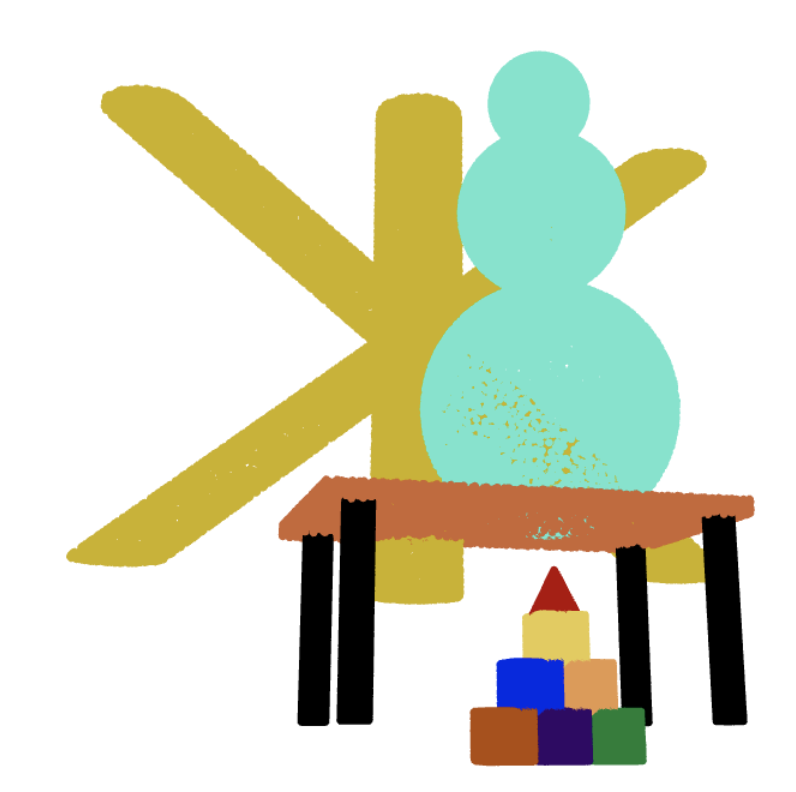

In [291]:
def dbscan(pcd, eps=0.02, min_points=10, is_visualize=True):
    '''Classtering
    ----------------------------------------------------
        eps : float
            радиус окрестности (в метрах), определяющий максимально 
            допустимое расстояние между соседними точками, которые 
            могут принадлежать одному кластеру
        min_points : int 
            минимальное количество точек, необходимое для образования 
            кластера. Если точка имеет меньше соседей, чем `min_points`
            она считается шумовой (outlier) и получает метку `-1`
    '''
    pcd = deepcopy(pcd)
    labels = np.array(pcd.cluster_dbscan(eps=eps, min_points=min_points, print_progress=True))

    max_label = labels.max()
    print(f"point cloud has {max_label + 1} clusters")
    colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
    colors[labels < 0] = 0
    pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
    if is_visualize:
        DisplayFigs.display_plotly_clouds((pcd, ))
    return pcd


def ransac(
    pcd, distance_threshold=0.05, ransac_n=3,
    num_iterations=1000, is_visualize=True
):
    '''Find planes
    ----------------------------------------------------
    distance_threshold : float
        максимальное расстояние, на котором точка может находиться от 
        предполагаемой плоскости, чтобы считаться принадлежащей ей 
        (включаться в набор inlier-ов)
    ransac_n : int 
        количество точек, случайно выбираемых на каждой итерации для 
        оценки параметров плоскости
    num_iterations : int
        число итераций, то есть сколько раз алгоритм будет случайным образом
        выбирать подмножества точек и проверять качество найденных моделей
    '''
    pcd = deepcopy(pcd)
    plane_model, inliers = pcd.segment_plane(distance_threshold=distance_threshold,
                                         ransac_n=ransac_n,
                                         num_iterations=num_iterations)
    [a, b, c, d] = plane_model
    print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

    inlier_cloud = pcd.select_by_index(inliers)
    inlier_cloud.paint_uniform_color([1.0, 0, 0])
    outlier_cloud = pcd.select_by_index(inliers, invert=True)

    if is_visualize:
        display(DisplayFigs.display_plotly_clouds((inlier_cloud, )))
        display(DisplayFigs.display_plotly_clouds((outlier_cloud, )))

def detect_planes(
    pcd, normal_variance_threshold_deg=60, coplanarity_deg=75, outlier_ratio=0.75, 
    min_plane_edge_length=0, min_num_points=0, knn=30, is_visualize=True
):
    '''Detect planar planes
    ----------------------------------------------------
        normal_variance_threshold_deg : float
            Максимально допустимое отклонение нормалей точек от нормали плоскости (в градусах).
            Меньшие значения дают более строгий отбор.
            Значение по умолчанию: 60°

        coplanarity_deg : float
            Допустимая дисперсия расстояний от точек до плоскости (в градусах).
            Меньшие значения обеспечивают более плотные и точные патчи.
            Значение по умолчанию: 75°

        outlier_ratio : float
            Максимальная доля выбросов в пределах плоскости.
            При превышении этого значения плоскость отбрасывается.
            Значение по умолчанию: 0.75

        min_plane_edge_length : float
            Минимальная длина ребра патча для отсечения ложных срабатываний.
            Рассчитывается как процент от размера сцены.
            Значение по умолчанию: 1% от размера сцены

        min_num_points : int
            Минимальное число точек в ячейке для попытки подгонки плоскости.
            Определяет глубину октодерева.
            Значение по умолчанию: 0.1% от общего числа точек

        search_param : KDTreeSearchParam
            Параметр поиска соседей при росте/слиянии патчей.
            Значение по умолчанию: KDTreeSearchParamKNN
    '''
    pcd = deepcopy(pcd)

    pcd.estimate_normals()

    oboxes = pcd.detect_planar_patches(
        normal_variance_threshold_deg=normal_variance_threshold_deg,
        coplanarity_deg=coplanarity_deg,
        outlier_ratio=outlier_ratio,
        min_plane_edge_length=min_plane_edge_length,
        min_num_points=min_num_points,
        search_param=o3d.geometry.KDTreeSearchParamKNN(knn=knn))

    print("Detected {} patches".format(len(oboxes)))

    geometries = []
    for obox in oboxes:
        mesh = o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(obox, scale=[1, 1, 0.0001])
        mesh.paint_uniform_color(obox.color)
        geometries.append(mesh)
        geometries.append(obox)

    if is_visualize:
        display(o3d.visualization.draw_geometries(geometries,))

    return geometries


def convex_hull(pcd, is_visualize=True):
    pcd = deepcopy(pcd)
    pcd.estimate_normals()
    hull, _ = pcd.compute_convex_hull()
    hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
    hull_ls.paint_uniform_color((1, 0, 0))

    if is_visualize:
        display(o3d.visualization.draw_geometries([pcd, hull_ls]))

    return hull_ls

#### Individual figures processing

In [ ]:
dbscan(snowman_transform, eps=0.05, min_points=12)
ransac(snowman_transform)
geometries = detect_planes(snowman_transform, normal_variance_threshold_deg=20, coplanarity_deg=50, knn=5)


<!-- 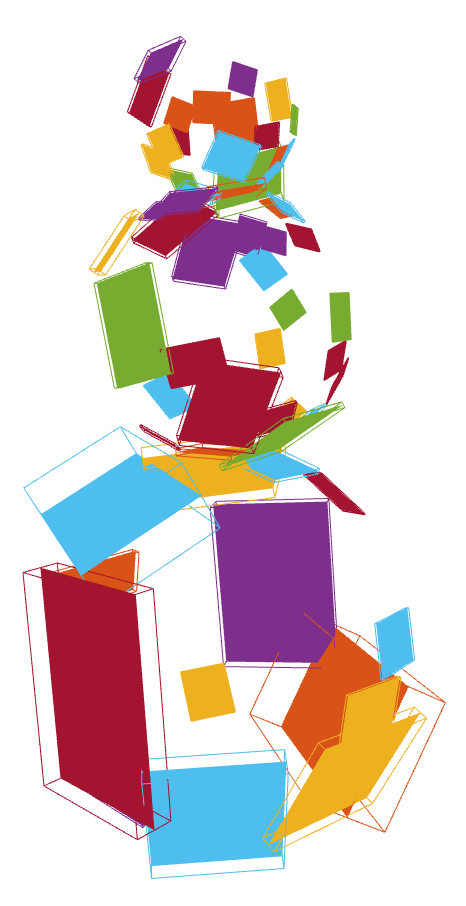 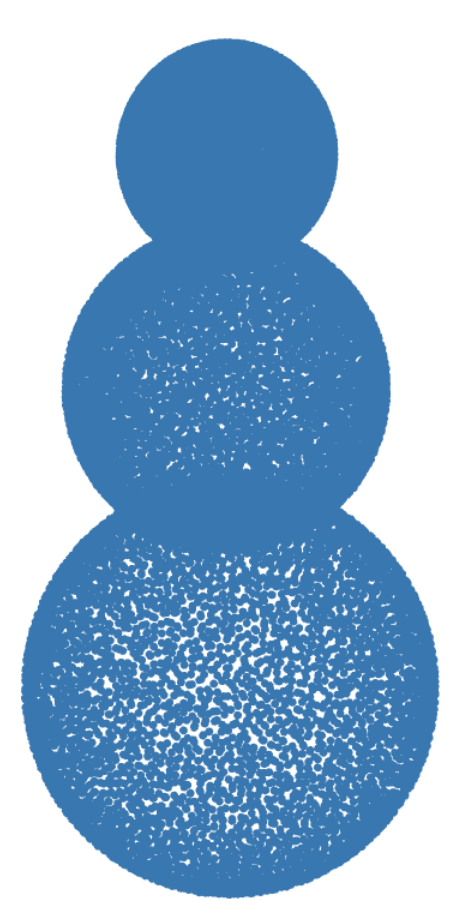 -->
| | DBSCAN | RANSAC (img1) | RANSAC (img2) | PLANAR PLANES |
|------------------------------|---------------------------------|----------------------------|----------------------------|----------------------------------|
| **PARAMS** | eps=0.05, min_points=12 | default |  | normal_variance_threshold_deg=20, coplanarity_deg=50, knn=5 |
| **RESULT** | point cloud has 1 clusters 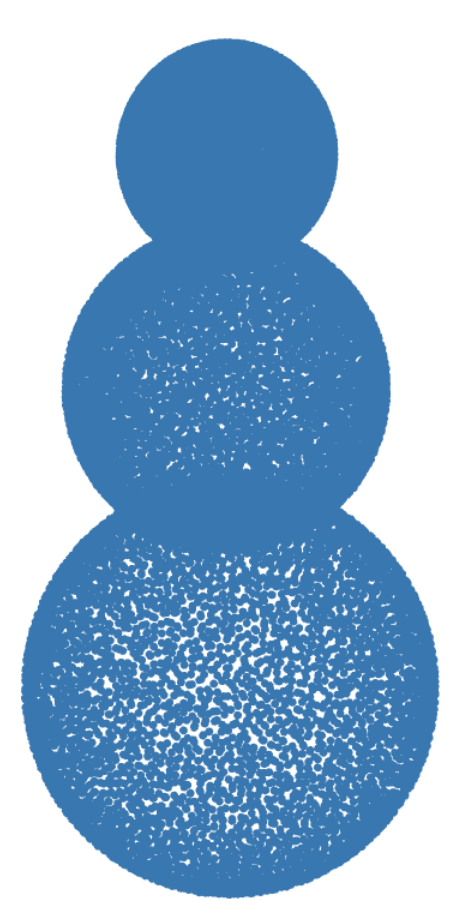 | Plane equation: -0.53x + 0.85y + 0.00z + 0.07 = 0 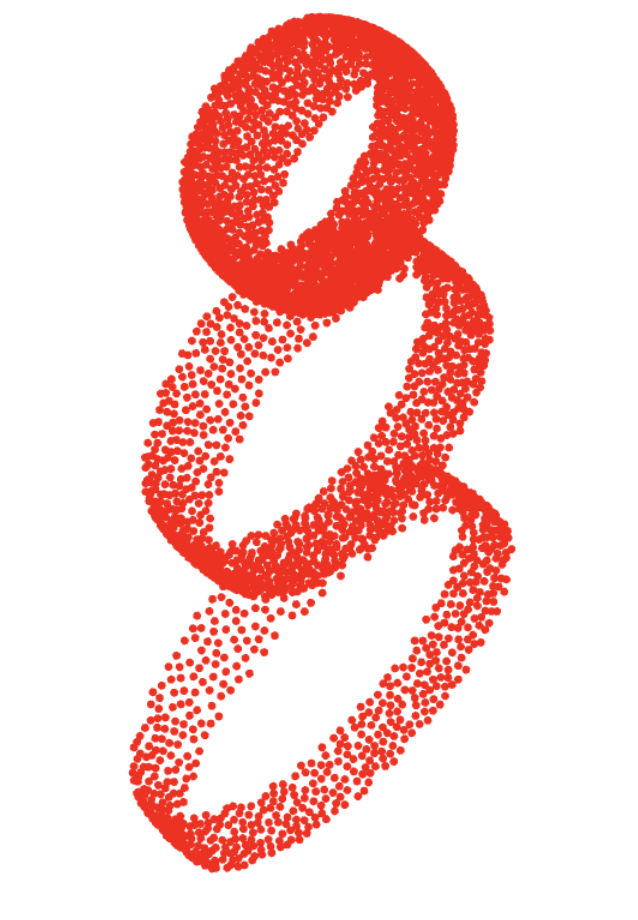 | 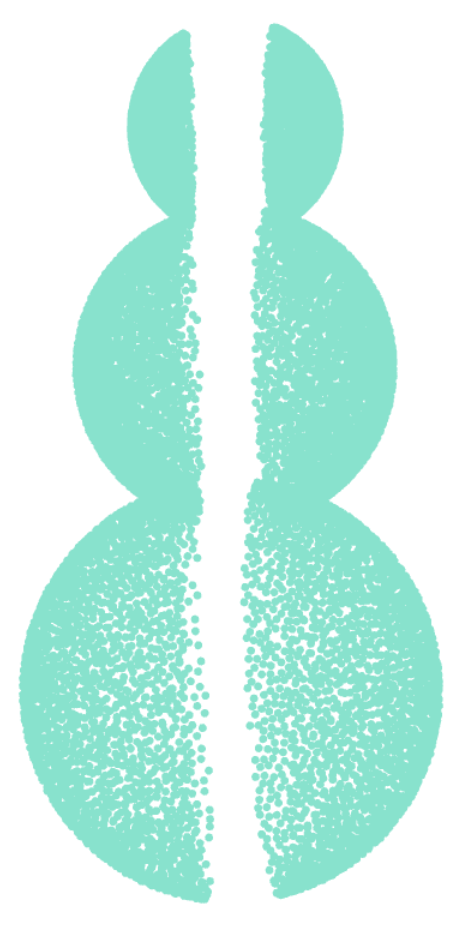 | Detected 58 patches 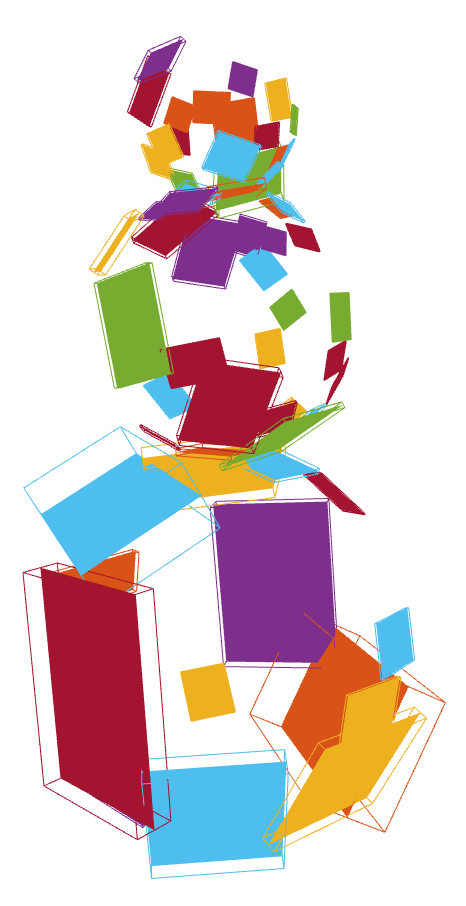 |
| **COMMENT** | Текущие параметры позволили выделить снеговига одним предметом | В местах соприкосновения сфер алгоритм выделяет отдельную плоскость | | Плоскости описывают форму снеговика |


In [ ]:
dbscan(table_transform)
ransac(table_transform, distance_threshold=0.09, ransac_n=12)
geometries = detect_planes(table_transform)


| | DBSCAN | RANSAC | PLANAR PLANES |
|------------------------------|----------------------------|----------------------------|----------------------------------|
| **PARAMS** | default | distance_threshold=0.09, ransac_n=12 | default |
| **RESULT** | point cloud has 2 clusters 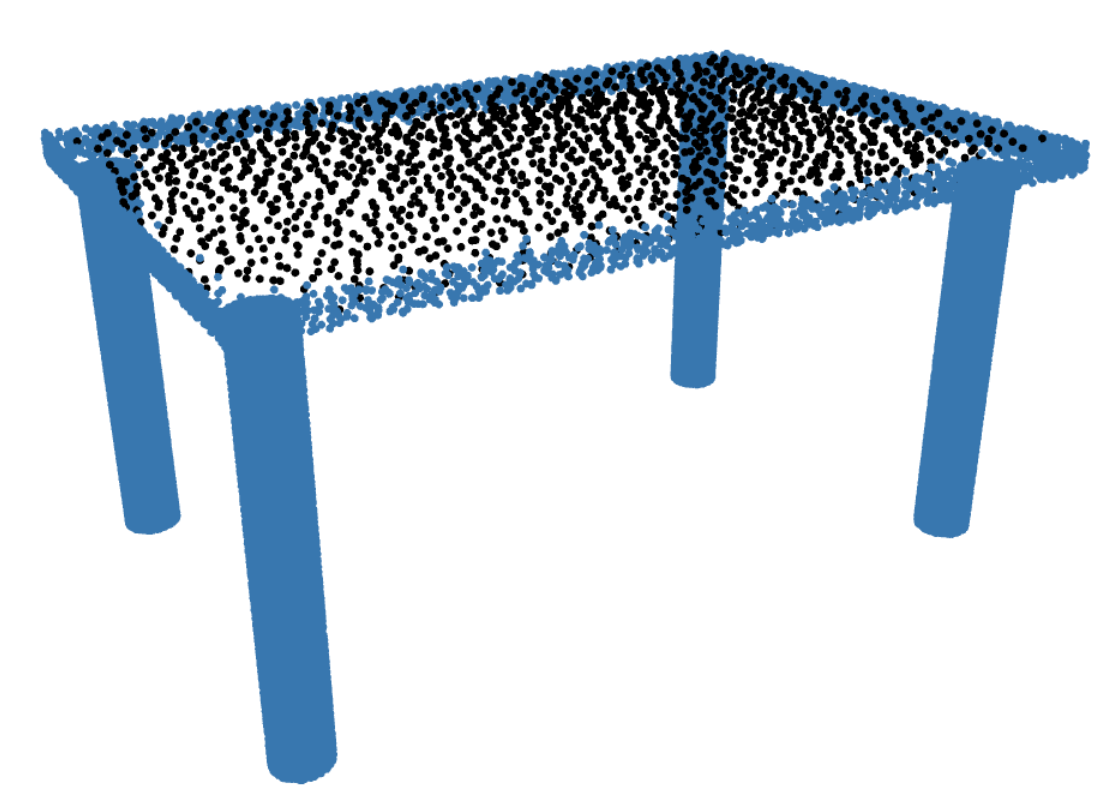 | Plane equation: 0.00x + -0.00y + 1.00z + 0.02 = 0 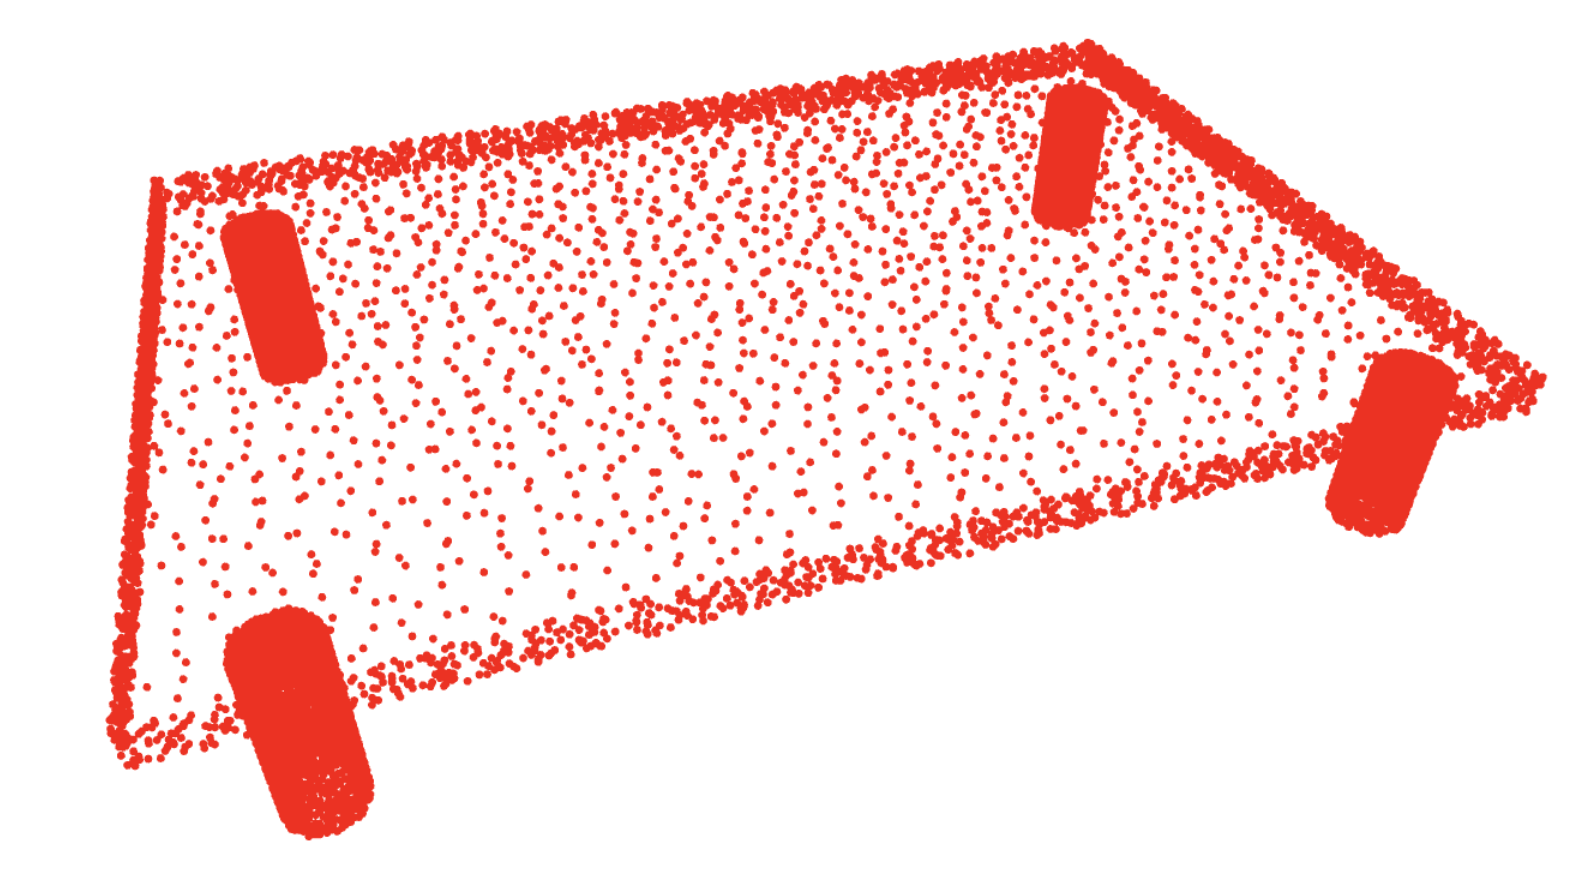 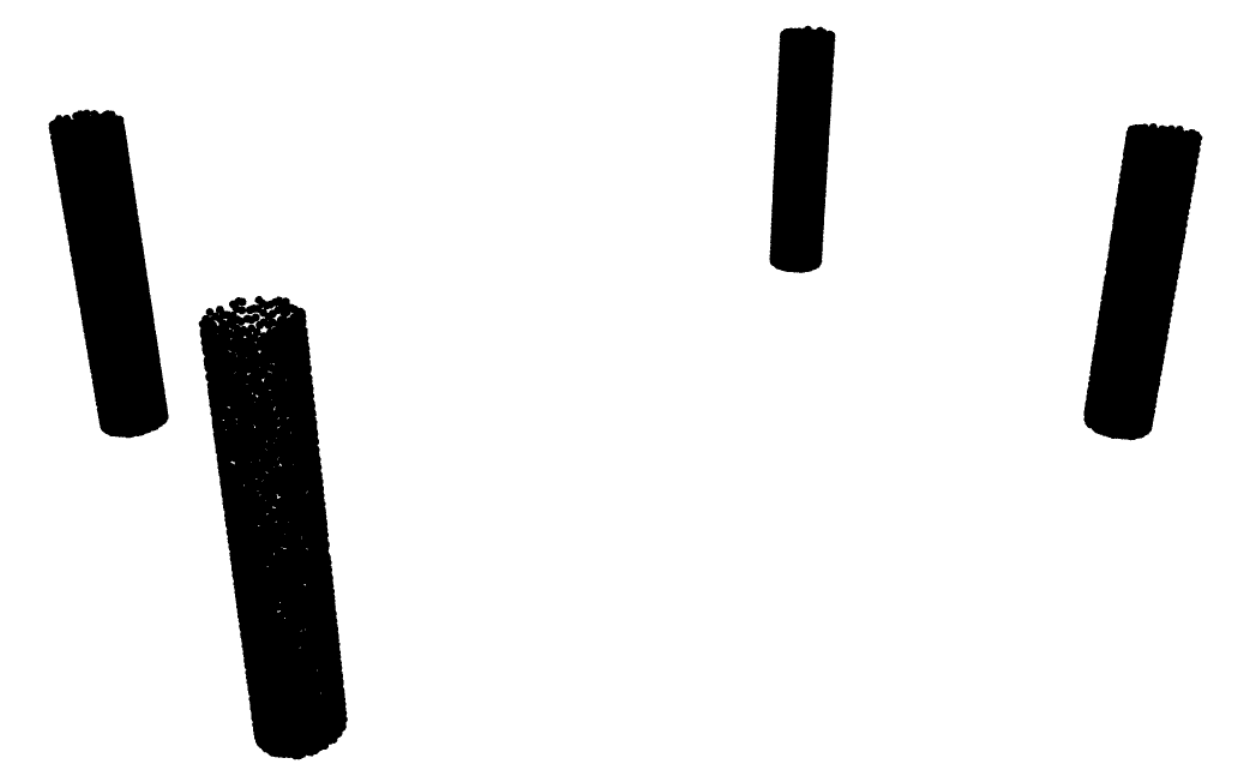 | Detected 30 patches 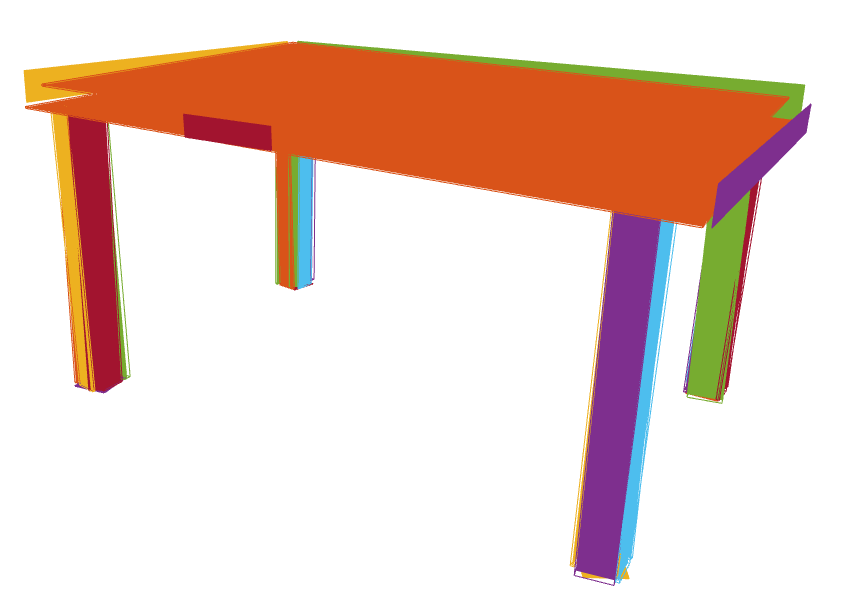 |
| **COMMENT** | На дефолтных параметрах столешница выделяется, как отдельный кластер | Попытка выделить плоскость столешницы | На дефолтных параметрах плоскости хорошо описывают стол |


In [ ]:
dbscan(star_transform, eps=0.05, min_points=15)
ransac(star_transform, distance_threshold=0.1, ransac_n=5)
geometries = detect_planes(
    star_transform, normal_variance_threshold_deg=19, 
    coplanarity_deg=7, knn=5
)

| | DBSCAN | RANSAC | PLANAR PLANES |
|------------------------------|----------------------------|----------------------------|----------------------------------|
| **PARAMS** | eps=0.05, min_points=15 | distance_threshold=0.1, ransac_n=5 |  normal_variance_threshold_deg=19, coplanarity_deg=7, knn=5 |
| **RESULT** | point cloud has 1 clusters 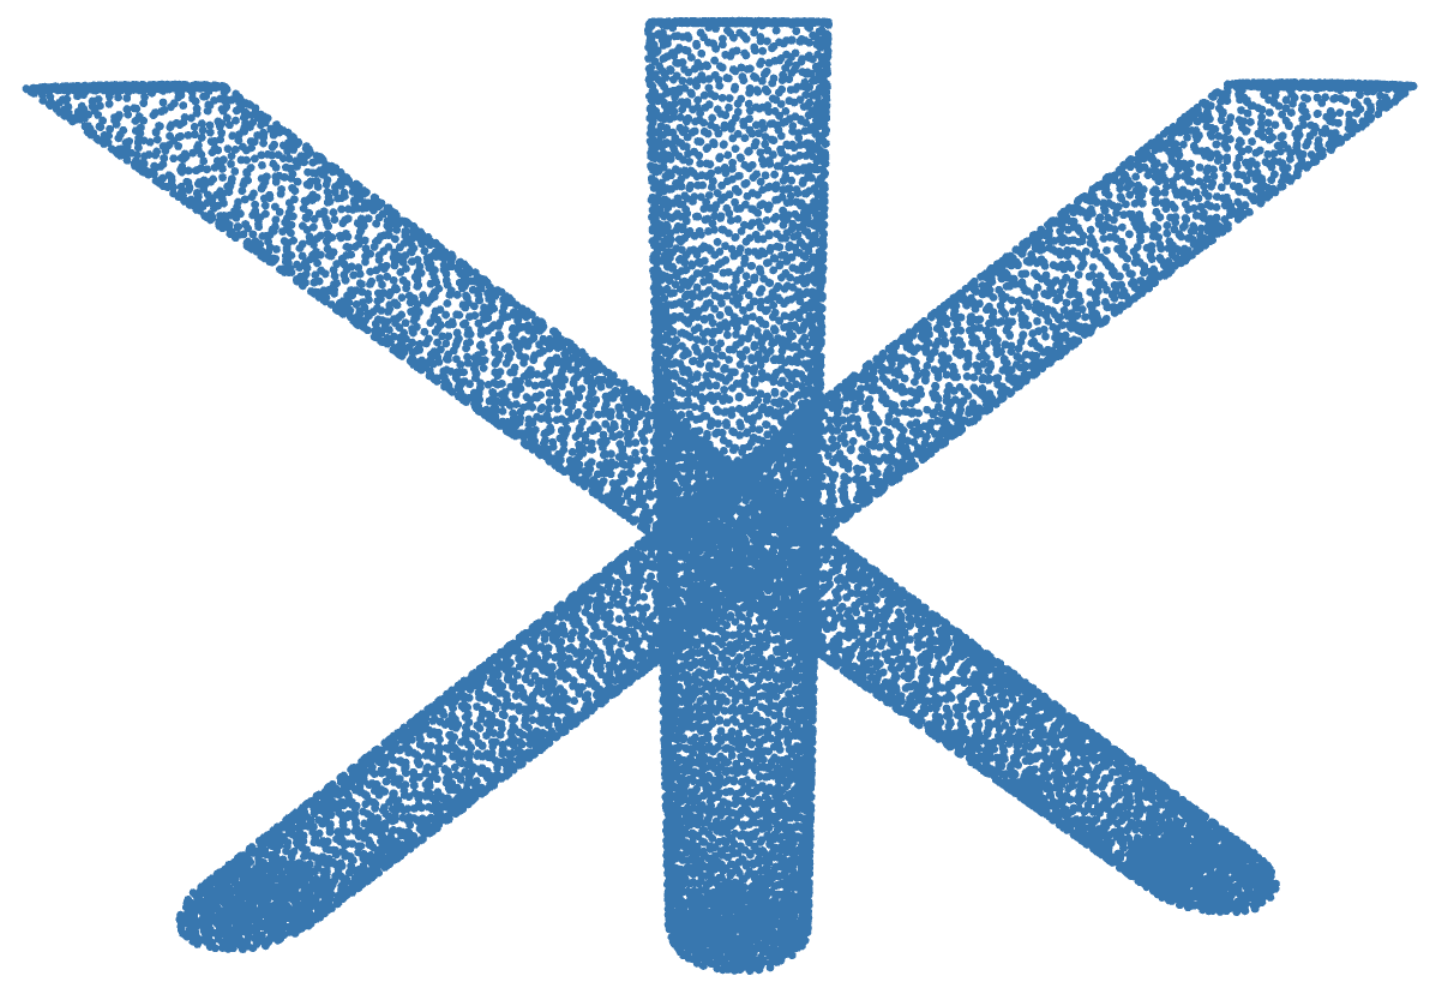 | Plane equation: -0.02x + 1.00y + 0.01z + 0.00 = 0 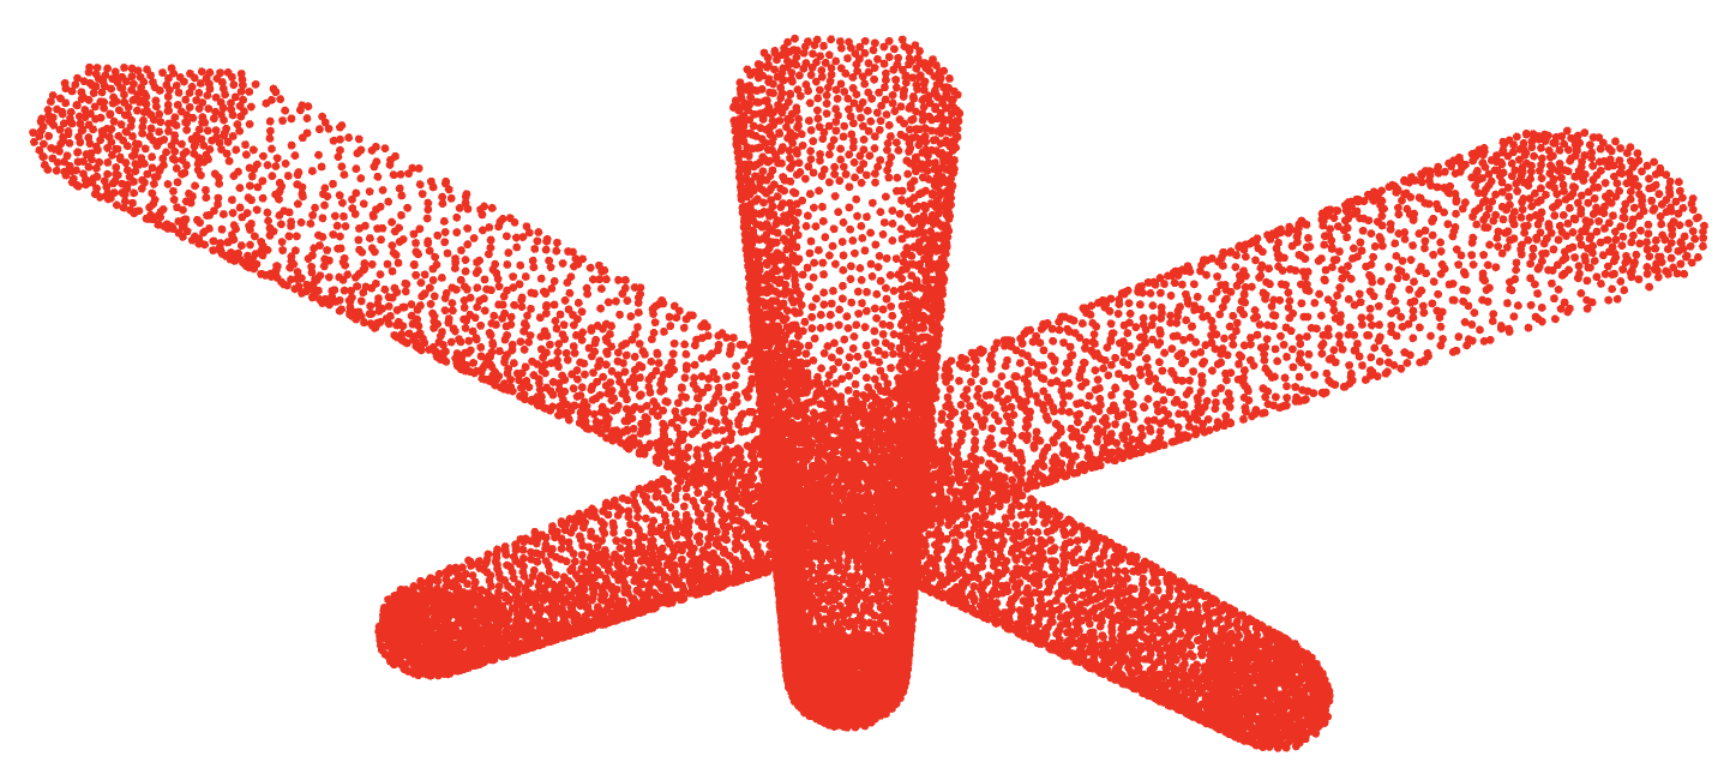 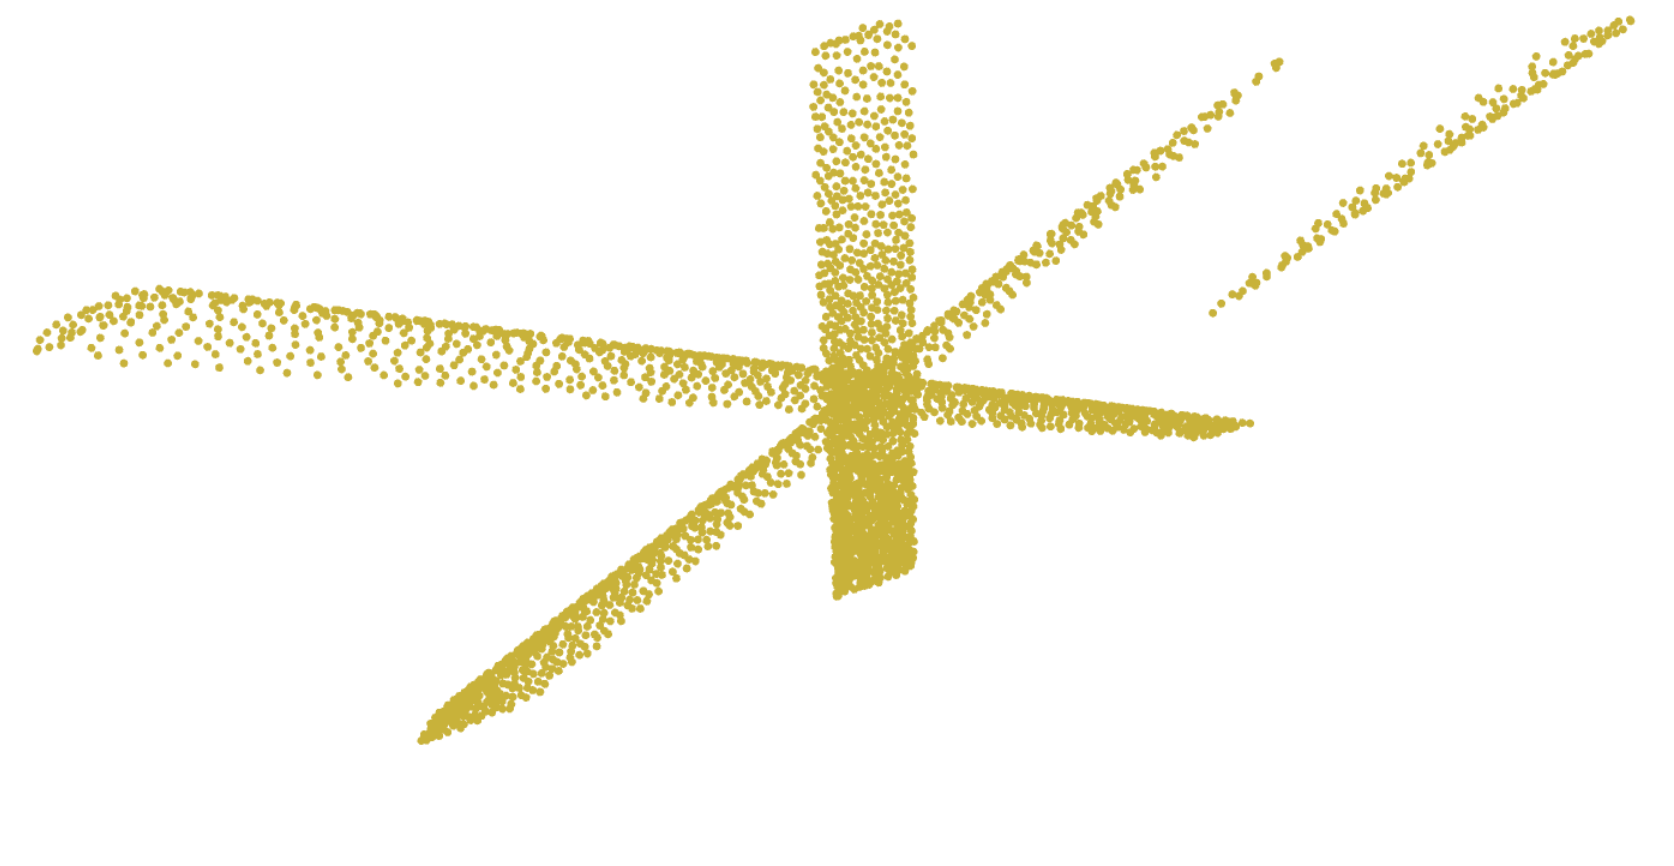 | Detected 48 patches 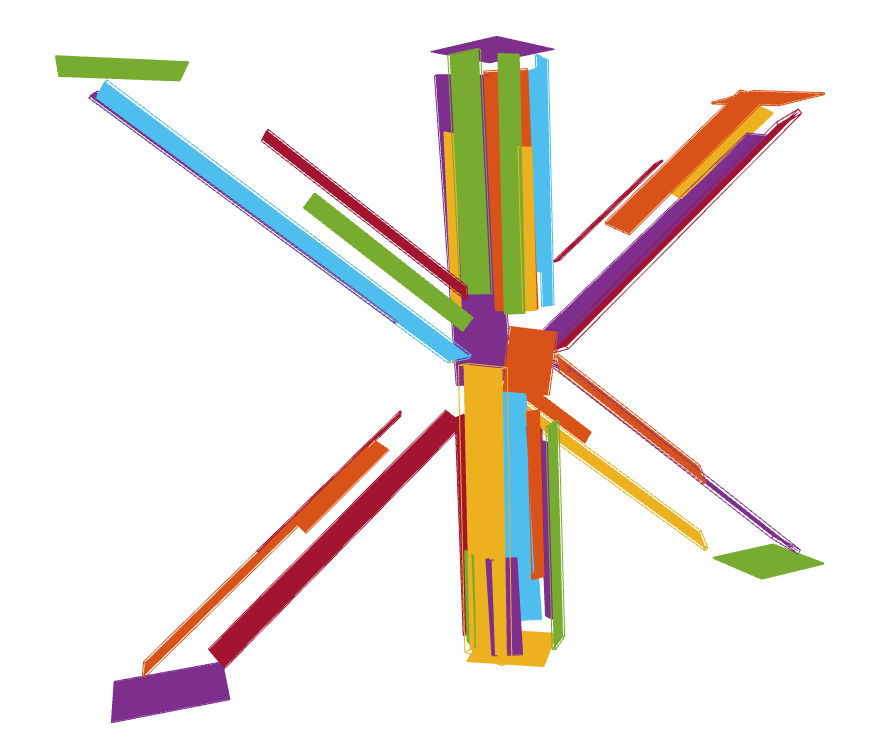 |
| **COMMENT** | Оптимальный размер радиуса и количество точек. При меньших значениях ошибочно выделяются доп области | Определилась однра из плоскостей звезды | Проблемно было выделить звезду без полных плоскостей вдоль каждого из боков |


In [ ]:
dbscan(pyramid_transform)
ransac(pyramid_transform, distance_threshold=0.005)
geometries = detect_planes(pyramid_transform, normal_variance_threshold_deg=16, 
    coplanarity_deg=7, knn=5
)


| | DBSCAN | RANSAC | PLANAR PLANES |
|------------------------------|----------------------------|----------------------------|----------------------------------|
| **PARAMS** | default | distance_threshold=0.005 | normal_variance_threshold_deg=16, coplanarity_deg=7, knn=5 |
| **RESULT** | point cloud has 1 clusters 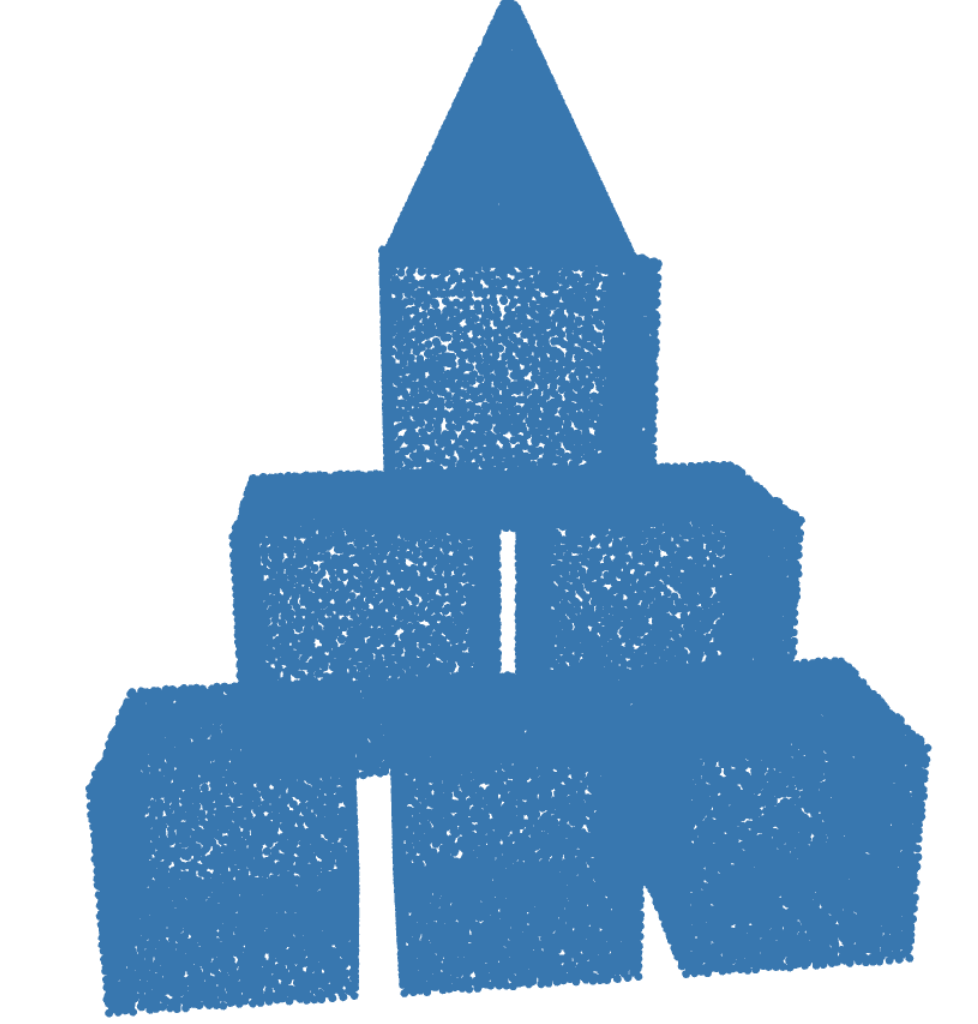 | Plane equation: 0.00x + 1.00y + 0.00z + -0.30 = 0 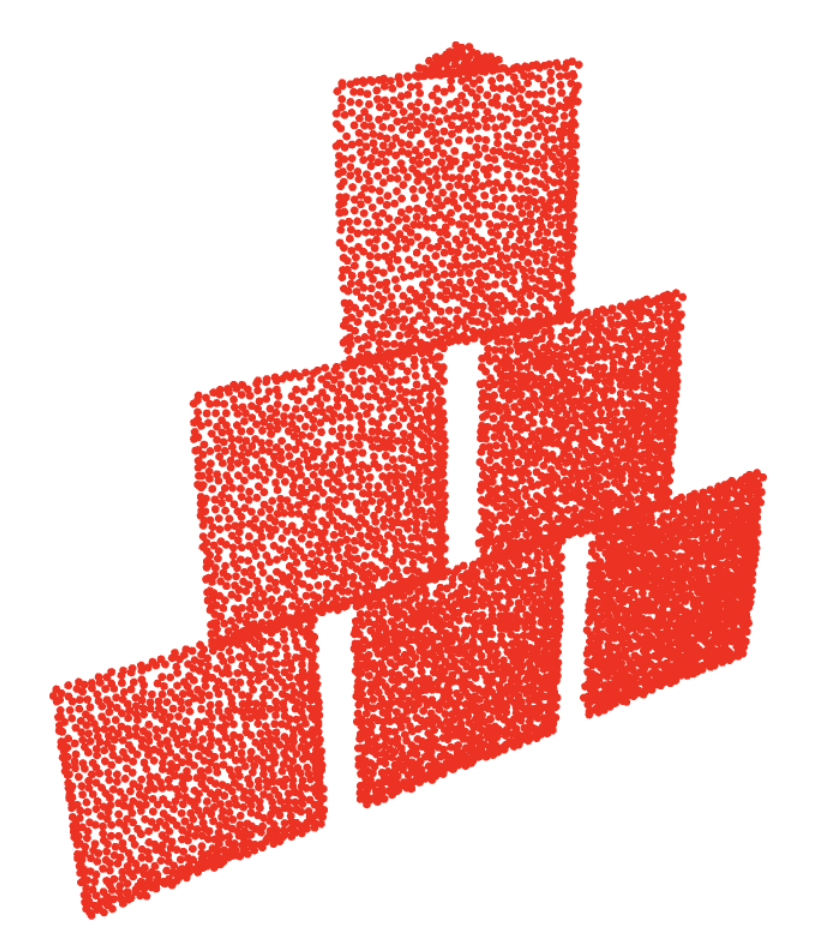 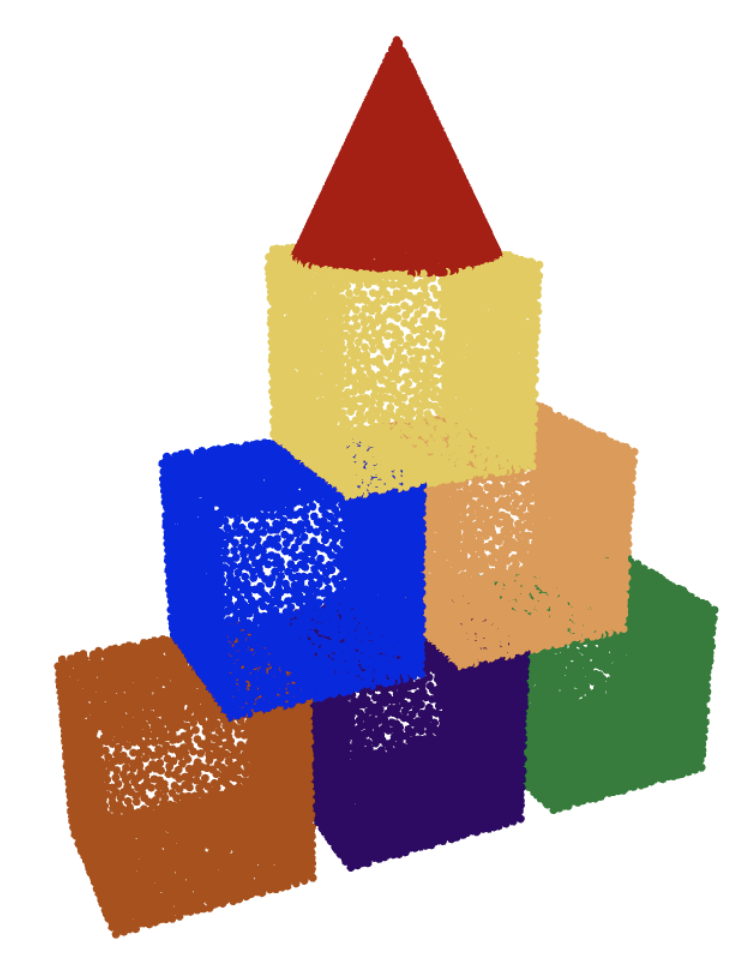 | Detected 39 patches 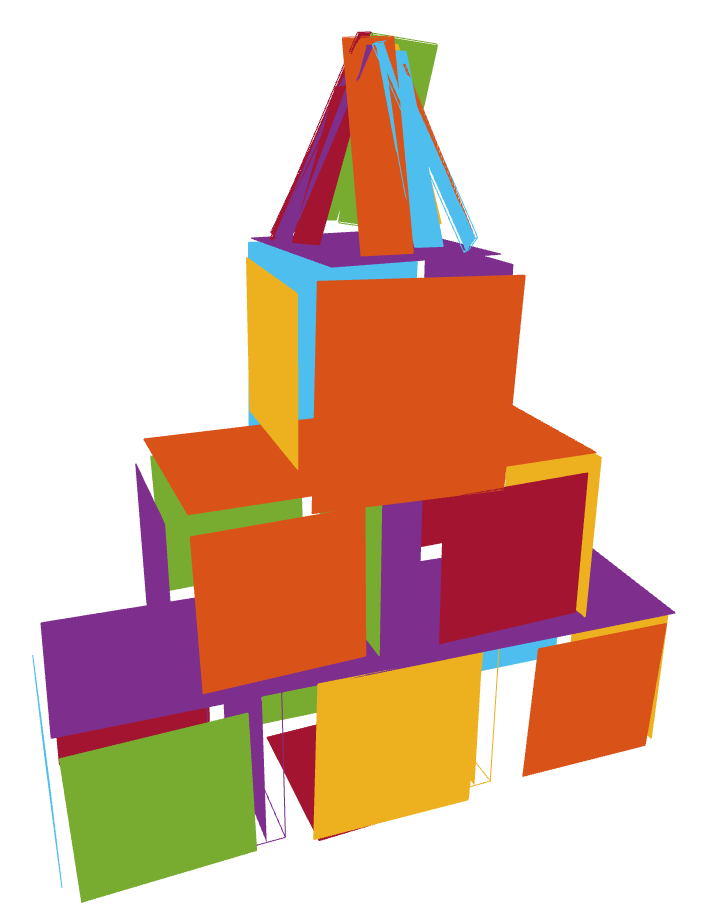 |
| **COMMENT** | Алгоритм отлично справился на дефолтных параметрах | Тут также спасает повышение distance_threshold | Аналогично, проблемно было выделить пирамиду без полных плоскостей вдоль каждого из боков |

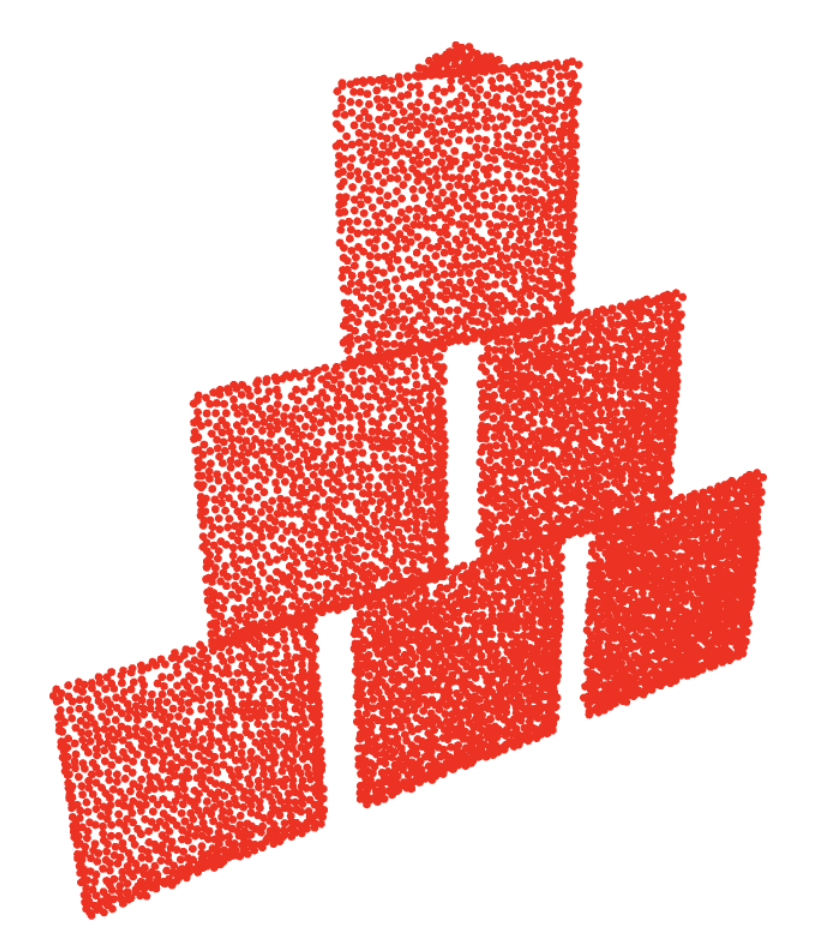

#### Main scene processing

In [ ]:
main_scene_dbscan = dbscan(main_scene, eps=0.04)
convex_hull(main_scene_dbscan)

DBSCAN-ном удалосб определить 2 кластера. Вероятно, это связано с тем, что 3 фигуры пересекаются

| 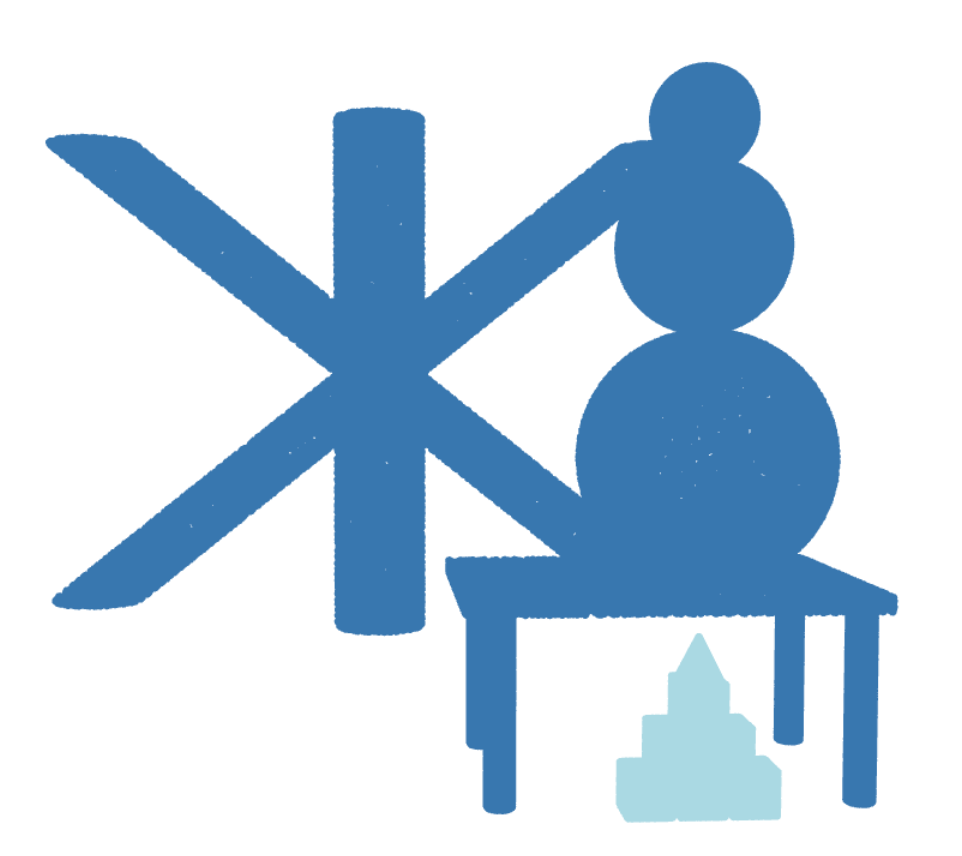 | 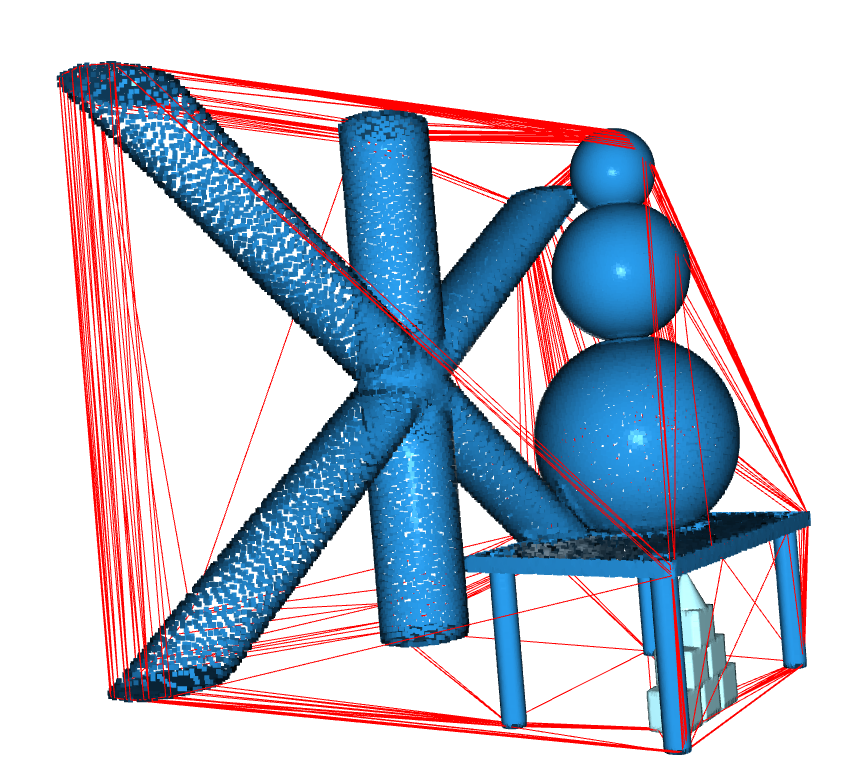 |
|----|----|

In [ ]:
ransac(main_scene, distance_threshold=0.05)

RANSAC определил плоскость по линии пересечения объектов:

Plane equation: 0.49x + 0.87y + 0.04z + -0.53 = 0

| 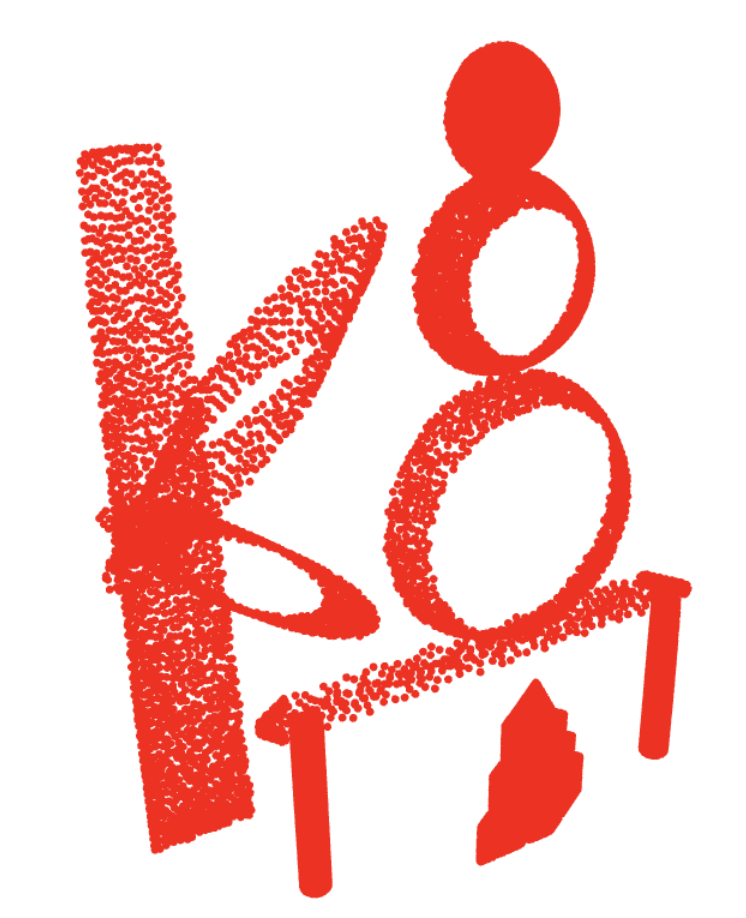 | 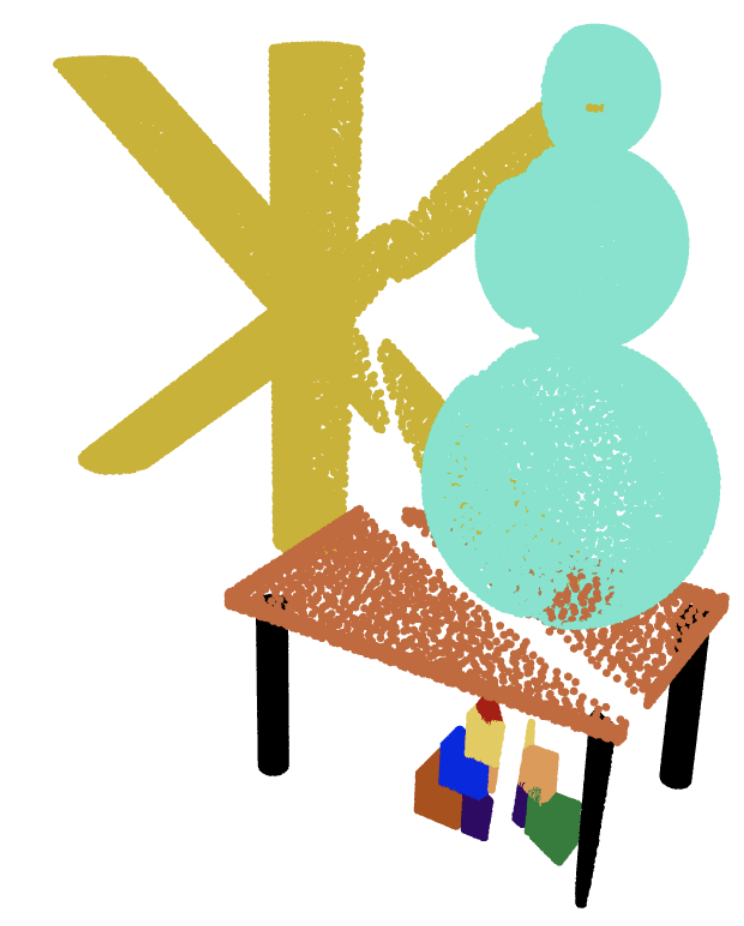 | 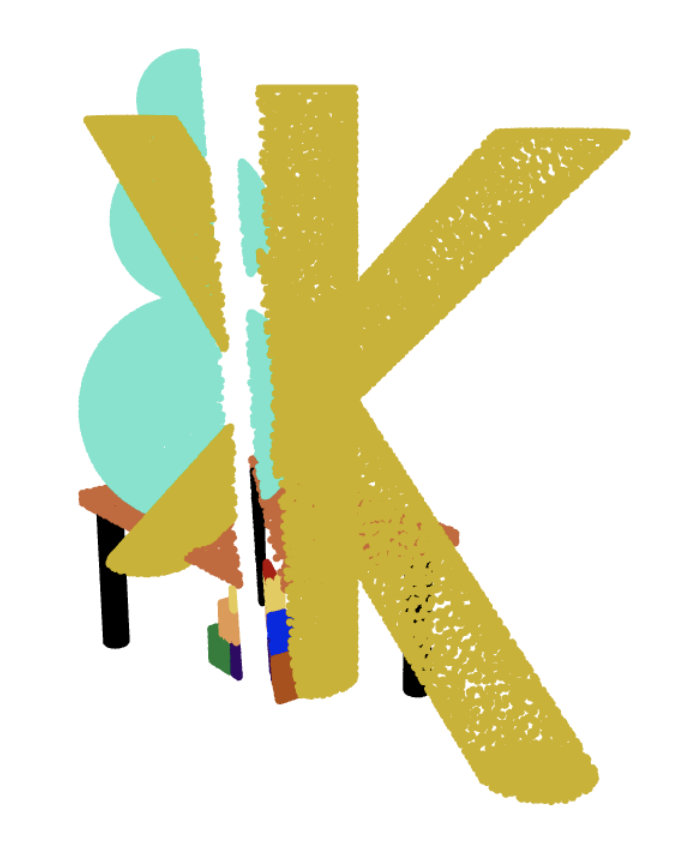 |
|----|----|----|

In [ ]:
detect_planes(main_scene, knn=5)

Никакие существенные изменения параметров не позволили в достаточной мере повлиять на детектирование плоских объектов, но благодаря снижению knn до 5 удалось сделать объекты различимыми
| 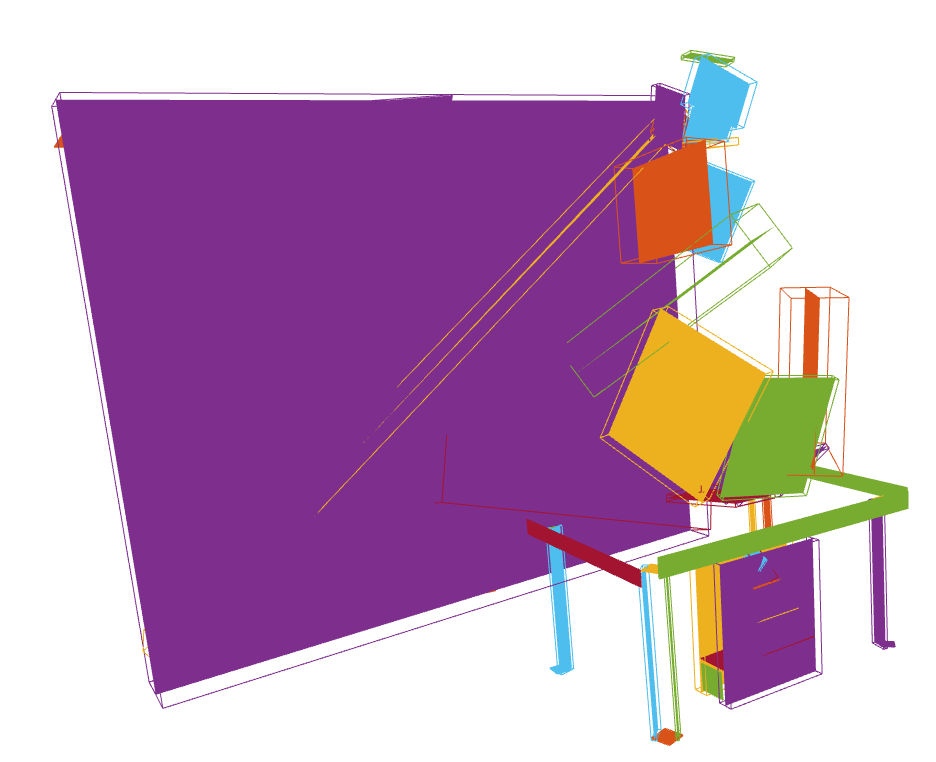 | 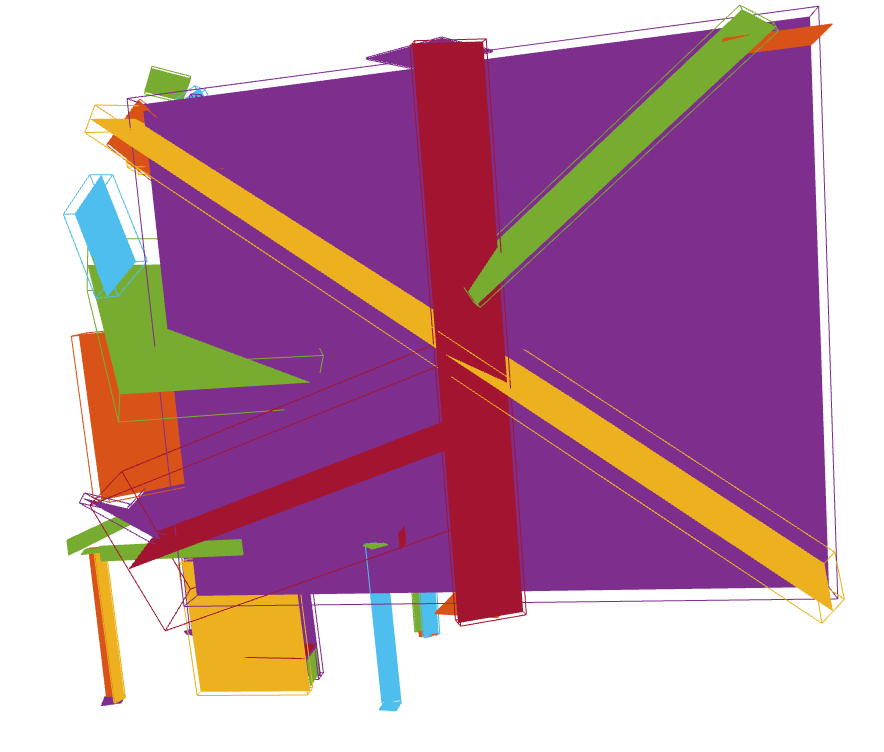 | 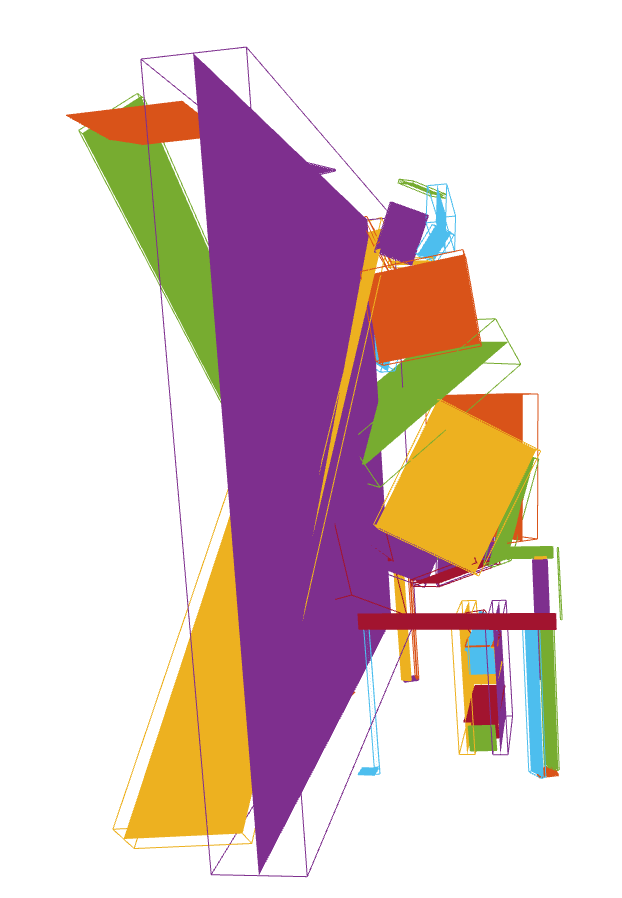 |
|----|----|----|